# Documentation

**Author:** Spencer Ressel

**Created:** June 14th, 2023

---

This code numerically solves the governing equations from Matsuno (1966). It was initially written by Daniel Lloveras as a project for the course ATM S 582.  The solver uses the pseudospectral method with leapfrog time differencing to solve the equations of motion.

---

# Imports

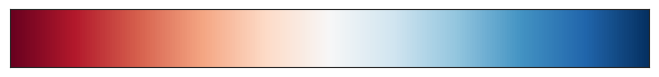

In [27]:
import os
os.chdir(f"/home/disk/eos7/sressel/research/thesis-work/python/numerical_solver/")
import sys
import time
from glob import glob
import numpy as np
import xarray as xr
from scipy import special
from numpy.fft import fft, ifft, fftfreq

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':22})
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
import seaborn as sns
Ahmed_cmap = sns.choose_colorbrewer_palette('diverging',as_cmap=True)
from matplotlib.animation import FuncAnimation
from tqdm import tqdm

# Cartopy
from cartopy import crs as ccrs
from cartopy import feature as cf
from cartopy import util as cutil
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter, LongitudeLocator, LatitudeLocator

import sys
sys.path.insert(0, '/home/disk/eos7/sressel/research/thesis-work/python/auxiliary_functions/')
import ipynb.fs.full.mjo_mean_state_diagnostics as mjo
from ipynb.fs.full.bmh_colors import bmh_colors
from ipynb.fs.full.rounding_functions import round_out, round_to_multiple

# Specify Physical Constants

In [28]:
simulation_moisture = True
moisture_advection = False
simulation_damping = True
moisture_coupling = True

############################ Fundamental Constants #############################
GRAVITY = 9.81                           # g [m/s^2]
EQUIVALENT_DEPTH = 250.                  # H [m]
CORIOLIS_PARAMETER = 2.29e-11            # ß [m^-1 s^-1]
EARTH_RADIUS = 6371.0072e3               # R_e [m]
AIR_DENSITY = 1.225                      # ρ_a [kg m^-3]
WATER_DENSITY = 997                      # ρ_w [kg m^-3]
LATENT_HEAT = 2260000                    # L_v [J kg^-1 K^-1]
SPECIFIC_HEAT = 1004                     # c_p [J kg^-1]
DIFFUSIVITY = 0.0001                     # D   [m^2 s^-1]

#### Ahmed (2021) constants ####
GROSS_DRY_STABILITY = 3.12e4             # M_s [K kg m^-2]

MOISTURE_SENSITIVITY = 0.00              # ε_q [s^-1]
TEMPERATURE_SENSITIVITY = 0.00           # ε_t [s^-1]
CLOUD_RADIATIVE_PARAMETER = 0            # r [-]

sigma_x_multiplier = 0                   # n_σ_x[-]
sigma_y_multiplier = 0                   # n_σ_y[-]

if simulation_damping == True:
    TEMPERATURE_SENSITIVITY = 1/(2*3600)   # ε_t [s^-1]
    CLOUD_RADIATIVE_PARAMETER = 0.2         # r [-]

if simulation_moisture == True:
    MOISTURE_SENSITIVITY = 1/(6*3600)       # ε_q [s^-1]
    
    if moisture_advection == True:
        sigma_x_multiplier = 1              # n_σ_x[-]
        sigma_y_multiplier = 1            # n_σ_y[-]

ZONAL_MOISTENING_PARAMETER = 5e-4*sigma_x_multiplier        # σ_x [K kg m^-3]
MERIDIONAL_MOISTENING_PARAMETER = 9e-9*sigma_y_multiplier   # σ_y [K kg m^-4]
##############################################################################


### Conversion factors ###
# METERS_PER_DEGREE = 110e3
METERS_PER_DEGREE = 2*np.pi*EARTH_RADIUS/360
# METERS_PER_DEGREE = 55e3
SECONDS_PER_DAY = 86400
COLUMN_AVERAGE_MASS = 1000*100/9.81
##########################


################################ Derived quantities ##################################
gravity_wave_phase_speed = np.sqrt(GRAVITY*EQUIVALENT_DEPTH)         # c_g [m s^-1]
time_scale = (CORIOLIS_PARAMETER*gravity_wave_phase_speed)**(-1/2)   # T [s]
length_scale = (gravity_wave_phase_speed/CORIOLIS_PARAMETER)**(1/2)  # L [m]
gross_moisture_stratification = 0.75*GROSS_DRY_STABILITY             # M_q [K kg m^-2]
effective_sensitivity = (
    MOISTURE_SENSITIVITY 
    + TEMPERATURE_SENSITIVITY*(1+CLOUD_RADIATIVE_PARAMETER)
)                                                                    # ε_a [s^-1]
effective_gross_moist_stability = (
    (GROSS_DRY_STABILITY - gross_moisture_stratification)/GROSS_DRY_STABILITY
)*(1+CLOUD_RADIATIVE_PARAMETER) - CLOUD_RADIATIVE_PARAMETER          # m_eff [-]
scaled_zonal_parameter = ZONAL_MOISTENING_PARAMETER/GROSS_DRY_STABILITY # ξ_x
scaled_meridional_parameter = MERIDIONAL_MOISTENING_PARAMETER/GROSS_DRY_STABILITY # ξ_y


print(f"{'Important Parameter Values':^60}")
print(f"{'':=^60}")
print(f"Dry Gravity Wave Phase Speed:     {gravity_wave_phase_speed:>10.2f} m/s")
print(f"Time Scale:                       {time_scale*24/SECONDS_PER_DAY:>10.2f} hours")
print(f"Length Scale:                     {length_scale/1e3:>10.2f} km")
print(f"")
print(f"Damping: {simulation_damping}")
print(f"- Temperature Sensitivity:        {3600*TEMPERATURE_SENSITIVITY:>10.2f} hr^-1")
print(f"- Cloud-Radiative Parameter:      {CLOUD_RADIATIVE_PARAMETER:>10.2f}")
print(f"")
print(f"Moisture: {simulation_damping}")
print(f"- Moisture Sensitivity:           {3600*MOISTURE_SENSITIVITY:>10.2f} hr^-1")
print(f"- Zonal Moistening Parameter:     {sigma_x_multiplier:>10.2f} x {ZONAL_MOISTENING_PARAMETER:>0.1e}")
print(f"- Meridional Moistening Parameter:{sigma_y_multiplier:>10.2f} x {MERIDIONAL_MOISTENING_PARAMETER:>0.1e}")
print(f"{'':=^60}")
######################################################################################

                 Important Parameter Values                 
Dry Gravity Wave Phase Speed:          49.52 m/s
Time Scale:                             8.25 hours
Length Scale:                        1470.57 km

Damping: True
- Temperature Sensitivity:              0.50 hr^-1
- Cloud-Radiative Parameter:            0.20

Moisture: True
- Moisture Sensitivity:                 0.17 hr^-1
- Zonal Moistening Parameter:           0.00 x 0.0e+00
- Meridional Moistening Parameter:      0.00 x 0.0e+00


# Specify Simulation Parameters

In [29]:
########################### Define simiulaton grid ############################
n_days                   = 120                    # number of days in simulation
n_chunks                 = 4 
n_time_steps             = int(1.2*2**12)                # number of time steps
meridional_domain_length = 5000e3                # length of half y domain in m
# meridional_step_size     = 78.25e3                 # meridional grid spacing in m
# meridional_step_size     = 50e3                 # meridional grid spacing in m
meridional_step_size     = 100e3
zonal_domain_length      = 2*np.pi*EARTH_RADIUS  # length of x domain in m
# zonal_step_size          = 156.5e3                 # zonal grid spacing in m
zonal_step_size          = 200e3                 # zonal grid spacing in m

simulation_length = n_days*SECONDS_PER_DAY       # simulation length in seconds

if n_chunks == 1:
    time_points = np.linspace(
        0, 
        simulation_length, 
        n_time_steps
    )                                                # Array of simulation time points  
    
else:
    time_points = np.linspace(
        0,
        simulation_length,
        n_chunks*n_time_steps
    )

time_step = np.diff(time_points)[0]              # Length of a time step in s

meridional_gridpoints = np.arange(                                               
    -meridional_domain_length,
     meridional_domain_length+meridional_step_size,
     meridional_step_size
)                                                # meridional grid points

zonal_gridpoints = np.arange(                                               
    -zonal_domain_length/2,
     zonal_domain_length/2,
     zonal_step_size 
)                                                # zonal grid points 

nt = len(time_points)                            # number of time steps
ny = len(meridional_gridpoints)                  # number of zonal grid points
nx = len(zonal_gridpoints)                       # number of meridional grid points

# Define Fourier arrays 
zonal_wavenumber      = 2*np.pi*fftfreq(nx, zonal_step_size)       # zonal wavenumbers
meridional_wavenumber = 2*np.pi*fftfreq(ny, meridional_step_size)  # meridional wavenumbers
# meridional_wavenumber[ny//3:2*ny//3] = 0
frequencies           = 2*np.pi*fftfreq(nt, time_step)             # frequencies
# frequencies[nt//3:2*nt//3] = 0

# Calculate CFL condition
CFL_x = gravity_wave_phase_speed*time_step/zonal_step_size
CFL_y = gravity_wave_phase_speed*time_step/meridional_step_size

print(f"{'Simulation Parameters':^48}")
print(f"{'':=^48}")
print(
    f"{'Lx =':4}" + 
    f"{zonal_domain_length/1e3:>6.0f}{' km':<6}" + 
    f"{'| Δx = ':>5}" + 
    f"{zonal_step_size/1e3:>8.1f}" + 
    f"{' km':<5}" + 
    f"{'| nx = ':<5}" + 
    f"{nx:>5.0f}"
)
print(
    f"{'Ly =':4}" + 
    f"{2*meridional_domain_length/1e3:>6.0f}" + 
    f"{' km':<6}{'| Δy = ':>5}" + 
    f"{meridional_step_size/1e3:>8.1f}" + 
    f"{' km':<5}" + 
    f"{'| ny = ':<4}" + 
    f"{ny:>5.0f}"
)
print(
    f"{'T  =':4}" + 
    f"{simulation_length/SECONDS_PER_DAY:>6.0f}" + 
    f"{' days':<6}{'| Δt = ':>5}" + 
    f"{time_step:>8.1f}" + 
    f"{' sec':<5}" + 
    f"{'| nt = ':<5}" + 
    f"{nt:>5.0f}"
)
print(f"{'':=^48}")
# print(f"CFL_x = {CFL_x:0.3f}", end="")
# if (CFL_x < 1/(np.sqrt(2)*np.pi)):
#     print(", numerically stable ✔")
# else:
#     print(", CFL > 1/(π√2), numerically unstable!!")

    
# print(f"CFL_y = {CFL_y:0.3f}", end="")
# if (CFL_y < 1/(np.sqrt(2)*np.pi)):
#     print(", numerically stable ✔")
    
# else:
#     print(", CFL > 1/(π√2), numerically unstable!!")

print(f"CFL = {CFL_x + CFL_y:0.3f}", end="")
if (CFL_x + CFL_y < 1):
    print(", numerically stable ✔")
    
else:
    print(" > 1, numerically unstable!!")
    
print(f"{'':=^48}")
###########################################################################################

##### Plotting Parameters ####
# Specify quiver spacing
n_quiver_points = 10
zonal_quiver_plot_spacing = int((1/n_quiver_points/2)*zonal_domain_length/zonal_step_size)
meridional_quiver_plot_spacing  = int((1/n_quiver_points)*2*meridional_domain_length/meridional_step_size)
grid_scaling = 1e-6

             Simulation Parameters              
Lx = 40030 km   | Δx =    200.0 km  | nx =   201
Ly = 10000 km   | Δy =    100.0 km  | ny =   101
T  =   120 days | Δt =    527.4 sec | nt = 19660
CFL = 0.392, numerically stable ✔


## Document simulation parameters

In [30]:
if simulation_damping == True:
    damping_state = 'damped'
else:
    damping_state = 'free'

if simulation_moisture == True:
    moisture_state = 'moist'
else:
    moisture_state = 'dry'

if moisture_coupling == True:
    coupling_state = 'coupled'
else:
    coupling_state = 'uncoupled'

#### Document simulation details ####
os.chdir("/home/disk/eos7/sressel/research/thesis-work/python/numerical_solver/")
simulation_name = (
    f"epst={3600*TEMPERATURE_SENSITIVITY:0.2f}"
  + f"_epsq={3600*MOISTURE_SENSITIVITY:0.2f}"
  + f"_r={CLOUD_RADIATIVE_PARAMETER:0.1f}"
  + f"_nx={sigma_x_multiplier:0.1f}"
  + f"_ny={sigma_y_multiplier:0.1f}"
  + f"_{damping_state}-{moisture_state}-{coupling_state}-simulation"
)

output_file_directory = f"output/WTG/{simulation_name}"
if not os.path.exists(output_file_directory):
    os.mkdir(output_file_directory)
    print(f"Output folder created")
    print(f"Simulation details: {simulation_name}")
else:
    print(f"Output folder already created")
    print(f"Simulation details: {simulation_name}")

if os.path.exists(f"{output_file_directory}/documentation.txt"):
    print("Old documentation exists, updating")
    os.system(f"rm {output_file_directory}/documentation.txt")

f = open(f"{output_file_directory}/documentation.txt", "w+")

f.write(f"Physical Constants {'':=^50}\n")
f.write(f"gravity                                  {GRAVITY:>10.3f} m/s^2 \n")
f.write(f"equivalent depth                         {EQUIVALENT_DEPTH:>10.3f} m \n")
f.write(f"dry gravity wave phase speed             {gravity_wave_phase_speed:>10.3f} m s^-1 \n")
f.write(f"coriolis parameter                       {CORIOLIS_PARAMETER*1e11:>10.3f} x 10^-11 m^-1 s^-1 \n")
f.write(f"earth radius                             {EARTH_RADIUS/1e3:>10.3f} km \n")
f.write(f"air density                              {AIR_DENSITY:>10.3f} kg m^-3 \n")
f.write(f"water density                            {WATER_DENSITY:>10.3f} kg m^-3 \n")
f.write(f"latent heat of vaporization              {LATENT_HEAT/1e3:>10.3f} KJ kg^-1 \n")
f.write(f"specific heat capacity                   {SPECIFIC_HEAT:>10.3f} J kg^-1 K^-1 \n")
f.write(f"\n")

f.write(f"Ahmed 2021 Constants {'':=^50}\n")
f.write(f"gross dry stability                      {GROSS_DRY_STABILITY/1e4:>10.3f} x 10^4 K kg m^-2 \n")
f.write(f"gross mositure stratification            {gross_moisture_stratification/1e4:>10.3f} x 10^4 K kg m^-2 \n")
f.write(f"convective sensitivity to moisture       {3600*MOISTURE_SENSITIVITY:>10.3f} hr^-1 \n")
f.write(f"convective sensitivity to temperature    {3600*TEMPERATURE_SENSITIVITY:>10.3f} hr^-1 \n")
f.write(f"cloud radiative feedback parameter       {CLOUD_RADIATIVE_PARAMETER:>10.3f} \n")
f.write(f"zonal moisture gradient parameter        {ZONAL_MOISTENING_PARAMETER:>10.1e} K kg m^-3 \n")
f.write(f"meridional moisture gradient parameter   {MERIDIONAL_MOISTENING_PARAMETER:>10.1e} K kg m^-4 \n")
f.write(f"\n")

f.write(f"Other Parameters {'':=^50}\n")
f.write(f"length scale                             {length_scale/1e3:>10.3f} km \n")
f.write(f"time scale                               {time_scale/3600:>10.3f} hr \n")
f.write(f"CFL condition in x                       {CFL_x:>10.3f} \n")
f.write(f"CFL condition in y                       {CFL_y:>10.3f} \n")
f.write(f"\n")

f.write(f"Simulation Parameters {'':=^50}\n")
f.write(f"simulation length                        {n_days:>10.3f} days \n")
f.write(f"time step length                         {time_step/3600:>10.3f} hr \n")
f.write(f"number of time steps                     {nt:>10.3f} \n")
f.write(f"zonal domain length                      {zonal_domain_length/1e3:>10.3f} km \n")
f.write(f"zonal step size                          {zonal_step_size/1e3:>10.3f} km \n")
f.write(f"number of zonal steps                    {nx:>10.3f} \n")
f.write(f"meridional domain length                 {2*meridional_domain_length/1e3:>10.3f} km \n")
f.write(f"meridional step size                     {meridional_step_size/1e3:>10.3f} km \n")
f.write(f"number of meridional steps               {ny:>10.3f} \n")
f.write(f"{'':=^72}\n")

f.close()

print("Documentation created")

Output folder already created
Simulation details: epst=0.50_epsq=0.17_r=0.2_nx=0.0_ny=0.0_damped-moist-coupled-simulation
Old documentation exists, updating
Documentation created


# Plotting Functions

## Plot horizontal structure

In [31]:
def plot_horizontal_structure(
    frame_to_plot,
    zonal_gridpoints,
    meridional_gridpoints,
    time_points,
    zonal_velocity, 
    meridional_velocity, 
    column_temperature, 
    column_moisture, 
    xlims = (-180, 180),
    ylims = (-60,60),
    zonal_quiver_plot_spacing = 10,
    meridional_quiver_plot_spacing = 10,
    save_plot = False, 
    plotting_units='converted'
):
    
    if frame_to_plot > np.shape(zonal_velocity)[0]:
        raise ValueError(f"Frame out of range of array size: {frame_to_plot} > {np.shape(zonal_velocity)[0]}")
    
    # Set plotting options
    plt.style.use('default')
    plt.rcParams.update({'font.size':22})
    modified_cmap = mjo.modified_colormap('bwr', 'white', 0.15, 0.05)

    # Specify whether to plot the values in simulated units or converted units
    if plotting_units == 'natural':
        plotting_temperature = column_temperature
        temperature_units = r"$\frac{K \, kg}{m^2}$"
        plotting_moisture = column_moisture
        moisture_units = r"$\frac{K \, kg}{m^2}$"

    elif plotting_units == 'converted':
        # Convert the units of temperature and moisture
        average_temperature = np.copy(column_temperature)/COLUMN_AVERAGE_MASS
        equivalent_moisture = np.copy(column_moisture)/LATENT_HEAT*SPECIFIC_HEAT*1000/WATER_DENSITY

        plotting_temperature = average_temperature
        temperature_units = r"K"
        plotting_moisture = equivalent_moisture
        moisture_units = r"mm"

    # contour_scale = np.max(plotting_temperature[0])
    # contourf_scale = np.max(plotting_moisture[0])
    # quiver_scale = np.max(zonal_velocity[0])

    # Specify arguments for plotting the colors, contours, and quivers
    contour_args = {
        'levels' :  np.delete(np.linspace(
                        -round_out(np.nanmax(np.abs(plotting_temperature[frame_to_plot])), 'hundredths'), 
                         round_out(np.nanmax(np.abs(plotting_temperature[frame_to_plot])), 'hundredths'), 
                         11
                    ), [5]),
        'norm'   :  mcolors.CenteredNorm(),
        'colors' :  'black'
    }

    if simulation_moisture:
        contourf_args = {
            'levels' :  np.linspace(
                            -round_out(np.nanmax(np.abs(plotting_moisture[frame_to_plot])), 'tenths'),
                             round_out(np.nanmax(np.abs(plotting_moisture[frame_to_plot])), 'tenths'),
                             21
                        ),
            'norm'   :  mcolors.CenteredNorm(),
            # 'cmap'   : 'coolwarm'
            'cmap'   : Ahmed_cmap,
            'extend' : 'both'
        }

    quiver_scale = round_out(np.nanmax(np.abs(zonal_velocity[frame_to_plot])), 'tenths')
    quiver_args = {
        'color'       : 'k',
        'width'       : 0.0025,
        'angles'      : 'xy',
        'scale_units' : 'xy',
        'scale'       : quiver_scale
    }

    # Create a figure 
    fig = plt.figure(figsize=(16,6),dpi=500)
    
    # If the sim has mositure, add a colorbar
    if simulation_moisture:
        gs = GridSpec(1, 2, width_ratios = [100,2], figure=fig)
        qbar_ax = fig.add_subplot(gs[-1])
        
    # Without moisture, just one axis is required
    else:
        gs = GridSpec(1, 1, figure=fig)
        
    # Update the bounds and spacing of the GridSpec
    gs.update(left=0.1, right=0.9, top=0.99, bottom=0.1, wspace=0.05)

    # Add an axis for the initial condition
    ax = fig.add_subplot(gs[0])

    # Label the plot
    if frame_to_plot == 0:
        ax.set_title(f"Initial condition", pad=10)
        output_time_string = "initial-condition"
        
    elif time_points[frame_to_plot] <= 120*3600:
        output_time_units = 'hr'
        output_time_string = f"{time_points[frame_to_plot]/(3600):0.1f}-{output_time_units}"
        ax.set_title(f"Time: {time_points[frame_to_plot]/3600:0.1f} {output_time_units}", pad=10)
    
    else:
        output_time_units = 'days'
        output_time_string = f"{time_points[frame_to_plot]/(24*3600):0.1f}-{output_time_units}"
        ax.set_title(f"Time: {time_points[frame_to_plot]/(24*3600):0.1f} {output_time_units}", pad=10)
        
    # Plot column temperature as a contour
    T_cont = ax.contour(
        zonal_gridpoints*grid_scaling,
        meridional_gridpoints*grid_scaling,
        plotting_temperature[frame_to_plot],
        **contour_args
    )
    ax.clabel(T_cont, T_cont.levels, inline=True, fontsize=10)

    # Plot column moisture as colors
    if simulation_moisture:
        q_cont = plt.contourf(
            zonal_gridpoints*grid_scaling,
            meridional_gridpoints*grid_scaling,
            plotting_moisture[frame_to_plot],
            **contourf_args
        )
        
        cbar = fig.colorbar(
            q_cont, 
            cax=qbar_ax
        )
        cbar.set_ticks(contourf_args['levels'][::4])
        cbar.set_label(moisture_units, rotation=0, labelpad=15)

    # Plot zonal and meridional velocity using vectors
    quiv = ax.quiver(
        zonal_gridpoints[::zonal_quiver_plot_spacing]*grid_scaling,
        meridional_gridpoints[::meridional_quiver_plot_spacing]*grid_scaling,
        -zonal_velocity[frame_to_plot][::meridional_quiver_plot_spacing,::zonal_quiver_plot_spacing],
        -meridional_velocity[frame_to_plot][::meridional_quiver_plot_spacing,::zonal_quiver_plot_spacing],
        **quiver_args
    )
    ax.quiverkey(
        quiv,          
        0.79, 1.02,          
        U=quiver_scale,          
        label=f'{quiver_scale:0.2f} m/s',          
        coordinates='figure', labelpos='E',          
        color='black', labelcolor='black'
    )
    
    # Add a dashed line signifying the equator
    ax.axhline(y=0, ls='--', alpha=0.5, color='gray', lw=0.5)

    # Set tick labels in longitude/latitude coordinates
    longitude_ticks = np.arange(-180+60, 180+60, 60)
    longitude_labels = mjo.tick_labeller(longitude_ticks, direction='lon')
    ax.set_xticks(longitude_ticks*METERS_PER_DEGREE*grid_scaling, labels=longitude_labels)

    latitude_ticks = np.arange(-50, 50+20, 20)
    # latitude_ticks = np.arange(-10, 10+5, 5)
    latitude_labels = mjo.tick_labeller(latitude_ticks, direction='lat')
    ax.set_yticks(latitude_ticks*METERS_PER_DEGREE*grid_scaling, labels=latitude_labels)

    # Set the plot's meridional limits and aspect ratio 
    ax.set_xlim(xlims[0]*METERS_PER_DEGREE*grid_scaling,xlims[1]*METERS_PER_DEGREE*grid_scaling)
    ax.set_ylim(ylims[0]*METERS_PER_DEGREE*grid_scaling,ylims[1]*METERS_PER_DEGREE*grid_scaling)
    ax.set_aspect('auto')

    # Save the plot if specified
    if save_plot:
        print(
            f"Plot saved as: " 
          + f"{output_file_directory}/{initial_condition_name}_{output_time_string}" 
          + f"_horizontal_structure_{time.strftime('%Y%m%d-%H%M')}.png"
        )
        plt.savefig(
            f"{output_file_directory}/{initial_condition_name}_{output_time_string}" 
            + f"_horizontal_structure_{time.strftime('%Y%m%d-%H%M')}.png", 
            bbox_inches='tight'
        )
    else:
        plt.show()

## Animate solutions

In [32]:
def animate_horizontal_structure(
    zonal_gridpoints,
    meridional_gridpoints,
    time_points,
    zonal_velocity, 
    meridional_velocity, 
    column_temperature, 
    column_moisture, 
    xlims = (-180,180),
    ylims = (-50,50),
    starting_frame = 0,
    n_frames = 50,
    frame_interval = 50,
    plotting_units='converted'
):

    # Set plotting options
    plt.style.use('default')
    plt.rcParams.update({'font.size':22})
    modified_cmap = mjo.modified_colormap('bwr', 'white', 0.15, 0.05)

    # Specify whether to plot the values in simulated units or converted units
    if plotting_units == 'natural':
        plotting_temperature = column_temperature
        temperature_units = r"$\frac{K \, kg}{m^2}$"
        plotting_moisture = column_moisture
        moisture_units = r"$\frac{K \, kg}{m^2}$"

    elif plotting_units == 'converted':
        # Convert the units of temperature and moisture
        average_temperature = np.copy(column_temperature)/COLUMN_AVERAGE_MASS
        equivalent_moisture = np.copy(column_moisture)/LATENT_HEAT*SPECIFIC_HEAT*1000/WATER_DENSITY

        plotting_temperature = average_temperature
        temperature_units = r"K"
        plotting_moisture = equivalent_moisture
        moisture_units = r"mm"

    # Specify arguments for plotting the colors, contours, and quivers
    contour_args = {
        'levels' :  np.delete(np.linspace(
                        -round_out(np.max(np.abs(plotting_temperature)), 'tenths'), 
                         round_out(np.max(np.abs(plotting_temperature)), 'tenths'), 
                         11
                    ), [5]),
        'norm'   :  mcolors.CenteredNorm(),
        'colors' :  'black'
    }

    if simulation_moisture:
        contourf_args = {
            'levels' :  np.linspace(
                            -round_out(np.max(np.abs(plotting_moisture)), 'tenths'),
                             round_out(np.max(np.abs(plotting_moisture)), 'tenths'),
                             21
                        ),
            'norm'   :  mcolors.CenteredNorm(),
            'cmap'   : 'coolwarm'
        }

    quiver_scale = round_out(np.max(np.abs(zonal_velocity)), 'tenths')
    quiver_args = {
        'color'       : 'k',
        'width'       : 0.0025,
        'angles'      : 'xy',
        'scale_units' : 'xy',
        'scale'       : quiver_scale
    }

    # Animation parameters
    starting_frame = 0
    
    if (initial_wave == 'Kelvin') or (initial_wave == 'Rossby'): 
        # frame_interval = int((nt - starting_frame)/n_frames)
        frame_interval = int((np.shape(plotting_moisture)[0] - starting_frame)/n_frames)

    end_frame = starting_frame + n_frames*frame_interval
    frames = np.arange(starting_frame, end_frame, frame_interval)

    # Create a figure 
    fig = plt.figure(figsize=(16,6),dpi=300, layout='constrained')

    # If the sim has mositure, add a colorbar
    if simulation_moisture:
        gs = GridSpec(1, 2, width_ratios = [100,2], figure=fig)
        qbar_ax = fig.add_subplot(gs[-1])

    # Without moisture, just one axis is required
    else:
        gs = GridSpec(1, 1, figure=fig)

    # Update the bounds and spacing of the GridSpec
    gs.update(left=0.1, right=0.9, top=0.99, bottom=0.1, wspace=0.05)

    # Add an axis for the initial condition
    ax = fig.add_subplot(gs[0])

    # Label the plot
    ax.set_title(f"Time: {time_points[starting_frame]/SECONDS_PER_DAY:0.1f} days")

    # Plot column temperature as a contour
    T_cont = ax.contour(
        zonal_gridpoints*grid_scaling,
        meridional_gridpoints*grid_scaling,
        plotting_temperature[starting_frame],
        **contour_args
    )
    ax.clabel(T_cont, T_cont.levels, inline=True, fontsize=10)

    # Plot column moisture as colors
    if simulation_moisture:
        q_cont = plt.contourf(
            zonal_gridpoints*grid_scaling,
            meridional_gridpoints*grid_scaling,
            plotting_moisture[starting_frame],
            **contourf_args
        )

        cbar = fig.colorbar(
            q_cont, 
            cax=qbar_ax
        )
        cbar.set_ticks(contourf_args['levels'][::4])
        cbar.set_label(moisture_units, rotation=0, labelpad=15)

    # Plot zonal and meridional velocity using vectors
    quiv = ax.quiver(
        zonal_gridpoints[::zonal_quiver_plot_spacing]*grid_scaling,
        meridional_gridpoints[::meridional_quiver_plot_spacing]*grid_scaling,
        -zonal_velocity[starting_frame][::meridional_quiver_plot_spacing,::zonal_quiver_plot_spacing],
        -meridional_velocity[starting_frame][::meridional_quiver_plot_spacing,::zonal_quiver_plot_spacing],
        **quiver_args
    )
    quiver_label_text = f'{quiver_scale:0.2f} m/s'

    # Create a temporary text object to calculate its width
    temp_text = ax.text(0., 0., quiver_label_text)

    # Calculate the width of the label text
    bbox = ax.transAxes.inverted().transform_bbox(
        temp_text.get_window_extent(
            renderer=plt.gcf().canvas.get_renderer()
        )
    )
    # renderer=plt.gcf().canvas.get_renderer()
    label_width = bbox.x1  - bbox.x0

    x_coordinate = 0.99
    adjusted_x = x_coordinate - label_width
    temp_text.set_visible(False)  # Make the text object invisible
    ax.quiverkey(
        quiv,          
        adjusted_x, 1.035, 
        U=quiver_scale,          
        label=quiver_label_text,          
        coordinates='axes', labelpos='E',          
        color='black', labelcolor='black'
    )

    # Add a dashed line signifying the equator
    ax.axhline(y=0, ls='--', alpha=0.5, color='gray', lw=0.5)

    # Set tick labels in longitude/latitude coordinates
    longitude_ticks = np.arange(-180+60, 180+60, 60)
    longitude_labels = mjo.tick_labeller(longitude_ticks, direction='lon')
    ax.set_xticks(longitude_ticks*METERS_PER_DEGREE*grid_scaling, labels=longitude_labels)

    latitude_ticks = np.arange(-50, 50+20, 20)
    # latitude_ticks = np.arange(-10, 10+5, 5)
    latitude_labels = mjo.tick_labeller(latitude_ticks, direction='lat')
    ax.set_yticks(latitude_ticks*METERS_PER_DEGREE*grid_scaling, labels=latitude_labels)

    # Set the plot's meridional limits and aspect ratio 
    ax.set_xlim(xlims[0]*METERS_PER_DEGREE*grid_scaling, xlims[1]*METERS_PER_DEGREE*grid_scaling)
    ax.set_ylim(ylims[0]*METERS_PER_DEGREE*grid_scaling, ylims[1]*METERS_PER_DEGREE*grid_scaling)

    # Set plot aspect
    ax.set_aspect('auto')

    def update(plotting_index):

        # Clear the plot each frame
        ax.clear()

        # Set the title to be the current time of the frame
        ax.set_title(f"Time: {time_points[plotting_index]/SECONDS_PER_DAY:0.1f} days")

        # Plot filled temperature contours
        T_cont = ax.contour(
            zonal_gridpoints*grid_scaling,
            meridional_gridpoints*grid_scaling,
            plotting_temperature[plotting_index],
            **contour_args
        )
        ax.clabel(T_cont, T_cont.levels, inline=True, fontsize=10)

        # Plot moisture contours
        if simulation_moisture:
            q_cont = plt.contourf(
                zonal_gridpoints*grid_scaling,
                meridional_gridpoints*grid_scaling,
                plotting_moisture[plotting_index],
                **contourf_args
            )

            cbar = fig.colorbar(
                q_cont, 
                cax=qbar_ax
            )
            cbar.set_ticks(contourf_args['levels'][::4])
            cbar.set_label(moisture_units, rotation=0, labelpad=15)


        # Plot wind vectors
        quiv = ax.quiver(
            zonal_gridpoints[::zonal_quiver_plot_spacing]*grid_scaling,
            meridional_gridpoints[::meridional_quiver_plot_spacing]*grid_scaling,
            -zonal_velocity[plotting_index,::meridional_quiver_plot_spacing,::zonal_quiver_plot_spacing],
            -meridional_velocity[plotting_index,::meridional_quiver_plot_spacing,::zonal_quiver_plot_spacing],
            **quiver_args
        )

        ax.quiverkey(
            quiv,          
            adjusted_x, 1.035,         
            U=quiver_scale,          
            label=quiver_label_text,          
            coordinates='axes', labelpos='E',          
            color='black', labelcolor='black'
        )

        # Set the x and y ticks to be longitude/latitude respectively
        ax.set_xticks(longitude_ticks*METERS_PER_DEGREE*grid_scaling, labels=longitude_labels)
        ax.set_yticks(latitude_ticks*METERS_PER_DEGREE*grid_scaling, labels=latitude_labels)
        ax.set_xlim(xlims[0]*METERS_PER_DEGREE*grid_scaling, xlims[1]*METERS_PER_DEGREE*grid_scaling)
        ax.set_ylim(ylims[0]*METERS_PER_DEGREE*grid_scaling ,ylims[1]*METERS_PER_DEGREE*grid_scaling)
        

        if simulation_moisture:
            return T_cont, quiv, q_cont

        else:
            return T_cont, quiv,

    # Run the animation
    anim = FuncAnimation(fig, update, frames=tqdm(frames, ncols=100, position=0, leave=True), interval=300)

    anim.save(
        f"{output_file_directory}/{initial_condition_name}_animation_{time.strftime('%Y%m%d-%H%M')}.mp4", 
        dpi=300
    )

# Initial Conditions

## Initial Condition Function

In [33]:
def generate_initial_condition(
    save_initial_condition=False,
):
    
    """
    This function generates data for the initial two time steps required to perform leap-frog numerical integration. 
    Options include wave type, number of wavelengths in the zonal domain, whether to include damping, moisture, and moisture 
    coupling in the simulation, and whether or not to save the output data to a netCDF file. 
    
    Keyword arguments:
    initial_wave (str)            : The wave type to be used in the initial condition. 
                                    Options are 'Kelvin', 'Rossby', 'EIG', or 'WIG'
    n_wavelengths (int)           : The number of wavelengths in the zonal direction (default 1) 
    simulation_damping (bool)     : Whether the simulation is free or damped (default False)
    simulation_moisture (bool)    : Whether the simulation is dry or includes moisture (default False)
    moisture_coupling (bool)      : Whether the moisture in the simulation feeds back to 
                                    affect the dry variables (default False)
    save_initial_condition (bool) : Whether or not the initial condition data is saved to a netCDF file (default False)
    
    """
    initial_wavenumber = 2*np.pi*n_wavelengths/zonal_domain_length
    initial_temperature_anomaly = COLUMN_AVERAGE_MASS/1.6

    #### Initialize arrays
    zonal_velocity = np.zeros((2,ny,nx))
    meridional_velocity = np.zeros((2,ny,nx))
    column_temperature = np.zeros((2,ny,nx))
    column_moisture = np.zeros((2,ny,nx))

    # Generate data arrays 
    if initial_wave == 'Kelvin':

        # u(x,y,t=0) = c × ψ(y/L, 1) × e^(ikx) [m s^-1]
        zonal_velocity[0] = gravity_wave_phase_speed*np.real(
            np.einsum(
                'i,j->ij',
                mjo.parabolic_cylinder_function(meridional_gridpoints/length_scale, 0),
                np.exp(1j*initial_wavenumber*zonal_gridpoints)
            )
        )

        # <T>(x,y,t=0)
        column_temperature[0] = (GROSS_DRY_STABILITY/gravity_wave_phase_speed**2)*gravity_wave_phase_speed**2*np.real(
            np.einsum(
                'i,j->ij',
                mjo.parabolic_cylinder_function(meridional_gridpoints/length_scale, 0),
                np.exp(1j*initial_wavenumber*zonal_gridpoints)
            )
        )

        if simulation_moisture == True:
            column_moisture[0] = -(
                gross_moisture_stratification/gravity_wave_phase_speed**2
            )*gravity_wave_phase_speed**2*np.real(
                np.einsum(
                    'i,j->ij',
                    mjo.parabolic_cylinder_function(meridional_gridpoints/length_scale, 0),
                    np.exp(1j*initial_wavenumber*zonal_gridpoints)
                )
            )

        # Rescale the anomalies so that ϕ[0] has magnitude 'initial_geopotential_anomaly'
        zonal_velocity[0] *= initial_temperature_anomaly/np.max(column_temperature[0])
        column_moisture[0] *= initial_temperature_anomaly/np.max(column_temperature[0])
        column_temperature[0] *= initial_temperature_anomaly/np.max(column_temperature[0])


    else:
        if initial_wave == 'Rossby':
            initial_frequency = (
                CORIOLIS_PARAMETER*initial_wavenumber
                /(initial_wavenumber**2 + (CORIOLIS_PARAMETER/gravity_wave_phase_speed)*(2*mode_number+1))
            )

        elif initial_wave == 'EIG':
            initial_frequency = -gravity_wave_phase_speed*np.sqrt(
                    initial_wavenumber**2 + (CORIOLIS_PARAMETER/gravity_wave_phase_speed)*(2*mode_number + 1)
                )

        elif initial_wave == 'WIG':
            initial_frequency = gravity_wave_phase_speed*np.sqrt(
                    initial_wavenumber**2 + (CORIOLIS_PARAMETER/gravity_wave_phase_speed)*(2*mode_number + 1)
                )


        # v(x,y,t=0) = i(1/ß)(ω^2-(ck)^2) × ψ(y/L, m) × e^(ikx) [m s^-1]
        meridional_velocity[0] = np.real(
                np.einsum(
                    'i,j->ij',
                    (
                        1j*(initial_frequency**2 - gravity_wave_phase_speed**2*initial_wavenumber**2)*(1/CORIOLIS_PARAMETER)
                            *mjo.parabolic_cylinder_function(meridional_gridpoints/length_scale, mode_number)
                    ),
                    np.exp(1j*initial_wavenumber*zonal_gridpoints)
                )
            )

        # u(x,y,t=0) = L × (0.5(ω-ck)ψ(y/L, m+1) + m(ω+ck)ψ(y/L, m-1)) × e^(ikx) [m s^-1]
        zonal_velocity[0] = (gravity_wave_phase_speed/CORIOLIS_PARAMETER)**(1/2)*np.real(
                np.einsum(
                    'i,j->ij',
                    (
                        0.5*(initial_frequency - gravity_wave_phase_speed*initial_wavenumber)
                            *mjo.parabolic_cylinder_function(meridional_gridpoints/length_scale, mode_number + 1)
                        + mode_number*(initial_frequency + gravity_wave_phase_speed*initial_wavenumber)
                            *mjo.parabolic_cylinder_function(meridional_gridpoints/length_scale, mode_number - 1)
                    ),
                    np.exp(1j*initial_wavenumber*zonal_gridpoints)
                )
            )

        # <T>(x,y,t=0) =  (M_s/c) x L × (0.5(ω-ck)ψ(y/L, m+1) - m(ω+ck)ψ(y/L, m-1)) × e^(ikx) [K kg m^-2]
        column_temperature[0] = (
            GROSS_DRY_STABILITY/gravity_wave_phase_speed
        )*(gravity_wave_phase_speed/CORIOLIS_PARAMETER)**(1/2)*np.real(
                np.einsum(
                    'i,j->ij',
                    (
                        0.5*(initial_frequency - gravity_wave_phase_speed*initial_wavenumber)
                            *mjo.parabolic_cylinder_function(meridional_gridpoints/length_scale, mode_number + 1)
                        - mode_number*(initial_frequency + gravity_wave_phase_speed*initial_wavenumber)
                            *mjo.parabolic_cylinder_function(meridional_gridpoints/length_scale, mode_number - 1)
                    ),
                    np.exp(1j*initial_wavenumber*zonal_gridpoints)
                )
            )

        if simulation_moisture == True:
            column_moisture[0] = -(
                gross_moisture_stratification/gravity_wave_phase_speed
            )*(gravity_wave_phase_speed/CORIOLIS_PARAMETER)**(1/2)*np.real(
                    np.einsum(
                        'i,j->ij',
                        (
                            0.5*(initial_frequency - gravity_wave_phase_speed*initial_wavenumber)
                                *mjo.parabolic_cylinder_function(meridional_gridpoints/length_scale, mode_number + 1)
                            - mode_number*(initial_frequency + gravity_wave_phase_speed*initial_wavenumber)
                                *mjo.parabolic_cylinder_function(meridional_gridpoints/length_scale, mode_number - 1)
                        ),
                        np.exp(1j*initial_wavenumber*zonal_gridpoints)
                    )
                )

        # Rescale the anomalies so that ϕ[0] has magnitude 'initial_geopotential_anomaly'
        zonal_velocity[0] *= initial_temperature_anomaly/np.max(column_temperature[0])
        meridional_velocity[0] *= initial_temperature_anomaly/np.max(column_temperature[0])
        column_moisture[0] *= initial_temperature_anomaly/np.max(column_temperature[0])
        column_temperature[0] *= initial_temperature_anomaly/np.max(column_temperature[0])

    ########################### Initialize leapfrog method with one step forward ###########################
    ### Transform to wavenumber space
    ux_fft = fft(zonal_velocity[0],axis=1)
    vy_fft = fft(meridional_velocity[0],axis=0)
    Tx_fft = fft(column_temperature[0],axis=1)
    Ty_fft = fft(column_temperature[0],axis=0)

    ### Compute derivatives
    dudx_fft = 1j*zonal_wavenumber[None,:]*ux_fft
    dvdy_fft = 1j*meridional_wavenumber[:,None]*vy_fft
    dTdx_fft = 1j*zonal_wavenumber[None,:]*Tx_fft
    dTdy_fft = 1j*meridional_wavenumber[:,None]*Ty_fft

    ### Transform back to physical space
    dudx = np.real(ifft(dudx_fft,axis=1))
    dvdy = np.real(ifft(dvdy_fft,axis=0))
    dTdx = np.real(ifft(dTdx_fft,axis=1))
    dTdy = np.real(ifft(dTdy_fft,axis=0))

    ### Step forward one time step
    # u[1] = u[0] - Δt × (-ßyv[0] + (c^2/M_s)d<T>[0]/dx)
    zonal_velocity[1] = zonal_velocity[0] - time_step*(
        - CORIOLIS_PARAMETER*meridional_gridpoints[:,None]*meridional_velocity[0] 
        + (gravity_wave_phase_speed**2/GROSS_DRY_STABILITY)*dTdx
    )

    # v[1] = v[0] - Δt × (ßyu[0] + (c^2/M_s)d<T>[0]/dy)
    meridional_velocity[1] = meridional_velocity[0] - time_step*(
        + CORIOLIS_PARAMETER*meridional_gridpoints[:,None]*zonal_velocity[0] 
        + (gravity_wave_phase_speed**2/GROSS_DRY_STABILITY)*dTdy
    )

    # <T>[1] = <T>[0] - Δt × (M_s(du[0]/dx + dv[0]/dy) + ε_t(1+r)<T>[0] - ε_q(1+r)<q>)
    if moisture_coupling == True:
        column_temperature[1] = column_temperature[0] - time_step*(
            + GROSS_DRY_STABILITY*(dudx + dvdy) 
            + TEMPERATURE_SENSITIVITY*(1+CLOUD_RADIATIVE_PARAMETER)*column_temperature[0]
            - MOISTURE_SENSITIVITY*(1+CLOUD_RADIATIVE_PARAMETER)*column_moisture[0]
        )

    elif moisture_coupling == False:
        column_temperature[1] = column_temperature[0] - time_step*(
            + GROSS_DRY_STABILITY*(dudx + dvdy) 
            + TEMPERATURE_SENSITIVITY*(1+CLOUD_RADIATIVE_PARAMETER)*column_temperature[0]
        )

    if simulation_moisture == True:
        # <q>[1] = <q>[0] - Δt × (-σ_x×u[0] + σ_y×y×v[0] - M_q(du[0]/dx + dv[0]/dy) - ε_t<T>[0] + ε_q<q>[0])
        column_moisture[1] = column_moisture[0] - time_step*(
            - ZONAL_MOISTENING_PARAMETER*zonal_velocity[0]
            + MERIDIONAL_MOISTENING_PARAMETER*meridional_gridpoints[:,None]*meridional_velocity[0] 
            - gross_moisture_stratification*(dudx + dvdy) 
            - TEMPERATURE_SENSITIVITY*column_temperature[0]
            + MOISTURE_SENSITIVITY*column_moisture[0]   
        )

    ### Meridional boundary condition
    meridional_velocity[1,0] = 0.
    meridional_velocity[1,-1] = 0.
    
    zonal_velocity[0,0] = 0.
    zonal_velocity[0,-1] = 0

    column_temperature[0,0] = 0.
    column_temperature[0,-1] = 0

    column_moisture[0,0] = 0.
    column_moisture[0,-1] = 0
    
    if save_initial_condition == True:
        print("Attempting to save data...")
        initial_condition_data = xr.Dataset(
            data_vars = {
                'u' : (["it", "y", "x"], zonal_velocity[-2:]),
                'v' : (["it", "y", "x"], meridional_velocity[-2:]),
                'T' : (["it", "y", "x"], column_temperature[-2:]),
                'q' : (["it", "y", "x"], column_moisture[-2:])
            },
            coords = {
            "x" : zonal_gridpoints,
            "y" : meridional_gridpoints,
            "it": np.array([0,1])
            }
        )
        
        print(f"Data to be saved as: {output_file_directory}/{initial_condition_name}_intial-condition-data.nc")
        
        # Check if the data already exists
        if os.path.exists(f"{output_file_directory}/{initial_condition_name}_intial-condition-data.nc"):
            
            # Prompt the user to overwrite the existing data
            overwrite_data = input("Data already exists. Overwrite? [y/n]")
            if overwrite_data == 'y':
                os.system(f"rm {output_file_directory}/{initial_condition_name}_intial-condition-data.nc")
                print("Data overwritten")
                initial_condition_data.to_netcdf(f"{output_file_directory}/{initial_condition_name}_intial-condition-data.nc")
                print("Initial condition data saved as netCDF")
            else:
                print("Original data retained")
        else:
            initial_condition_data.to_netcdf(f"{output_file_directory}/{initial_condition_name}_intial-condition-data.nc")
            print("Initial condition data saved as netCDF")
    
    return zonal_velocity, meridional_velocity, column_temperature, column_moisture

## Specify initial conditions

Output directory: output/WTG/epst=0.50_epsq=0.17_r=0.2_nx=0.0_ny=0.0_damped-moist-coupled-simulation
Initial condition: k=2.0_m=1_Kelvin-wave

Attempting to save data...
Data to be saved as: output/WTG/epst=0.50_epsq=0.17_r=0.2_nx=0.0_ny=0.0_damped-moist-coupled-simulation/k=2.0_m=1_Kelvin-wave_intial-condition-data.nc


Data already exists. Overwrite? [y/n] y


Data overwritten
Initial condition data saved as netCDF
Plot saved as: output/WTG/epst=0.50_epsq=0.17_r=0.2_nx=0.0_ny=0.0_damped-moist-coupled-simulation/k=2.0_m=1_Kelvin-wave_initial-condition_horizontal_structure_20231102-1617.png


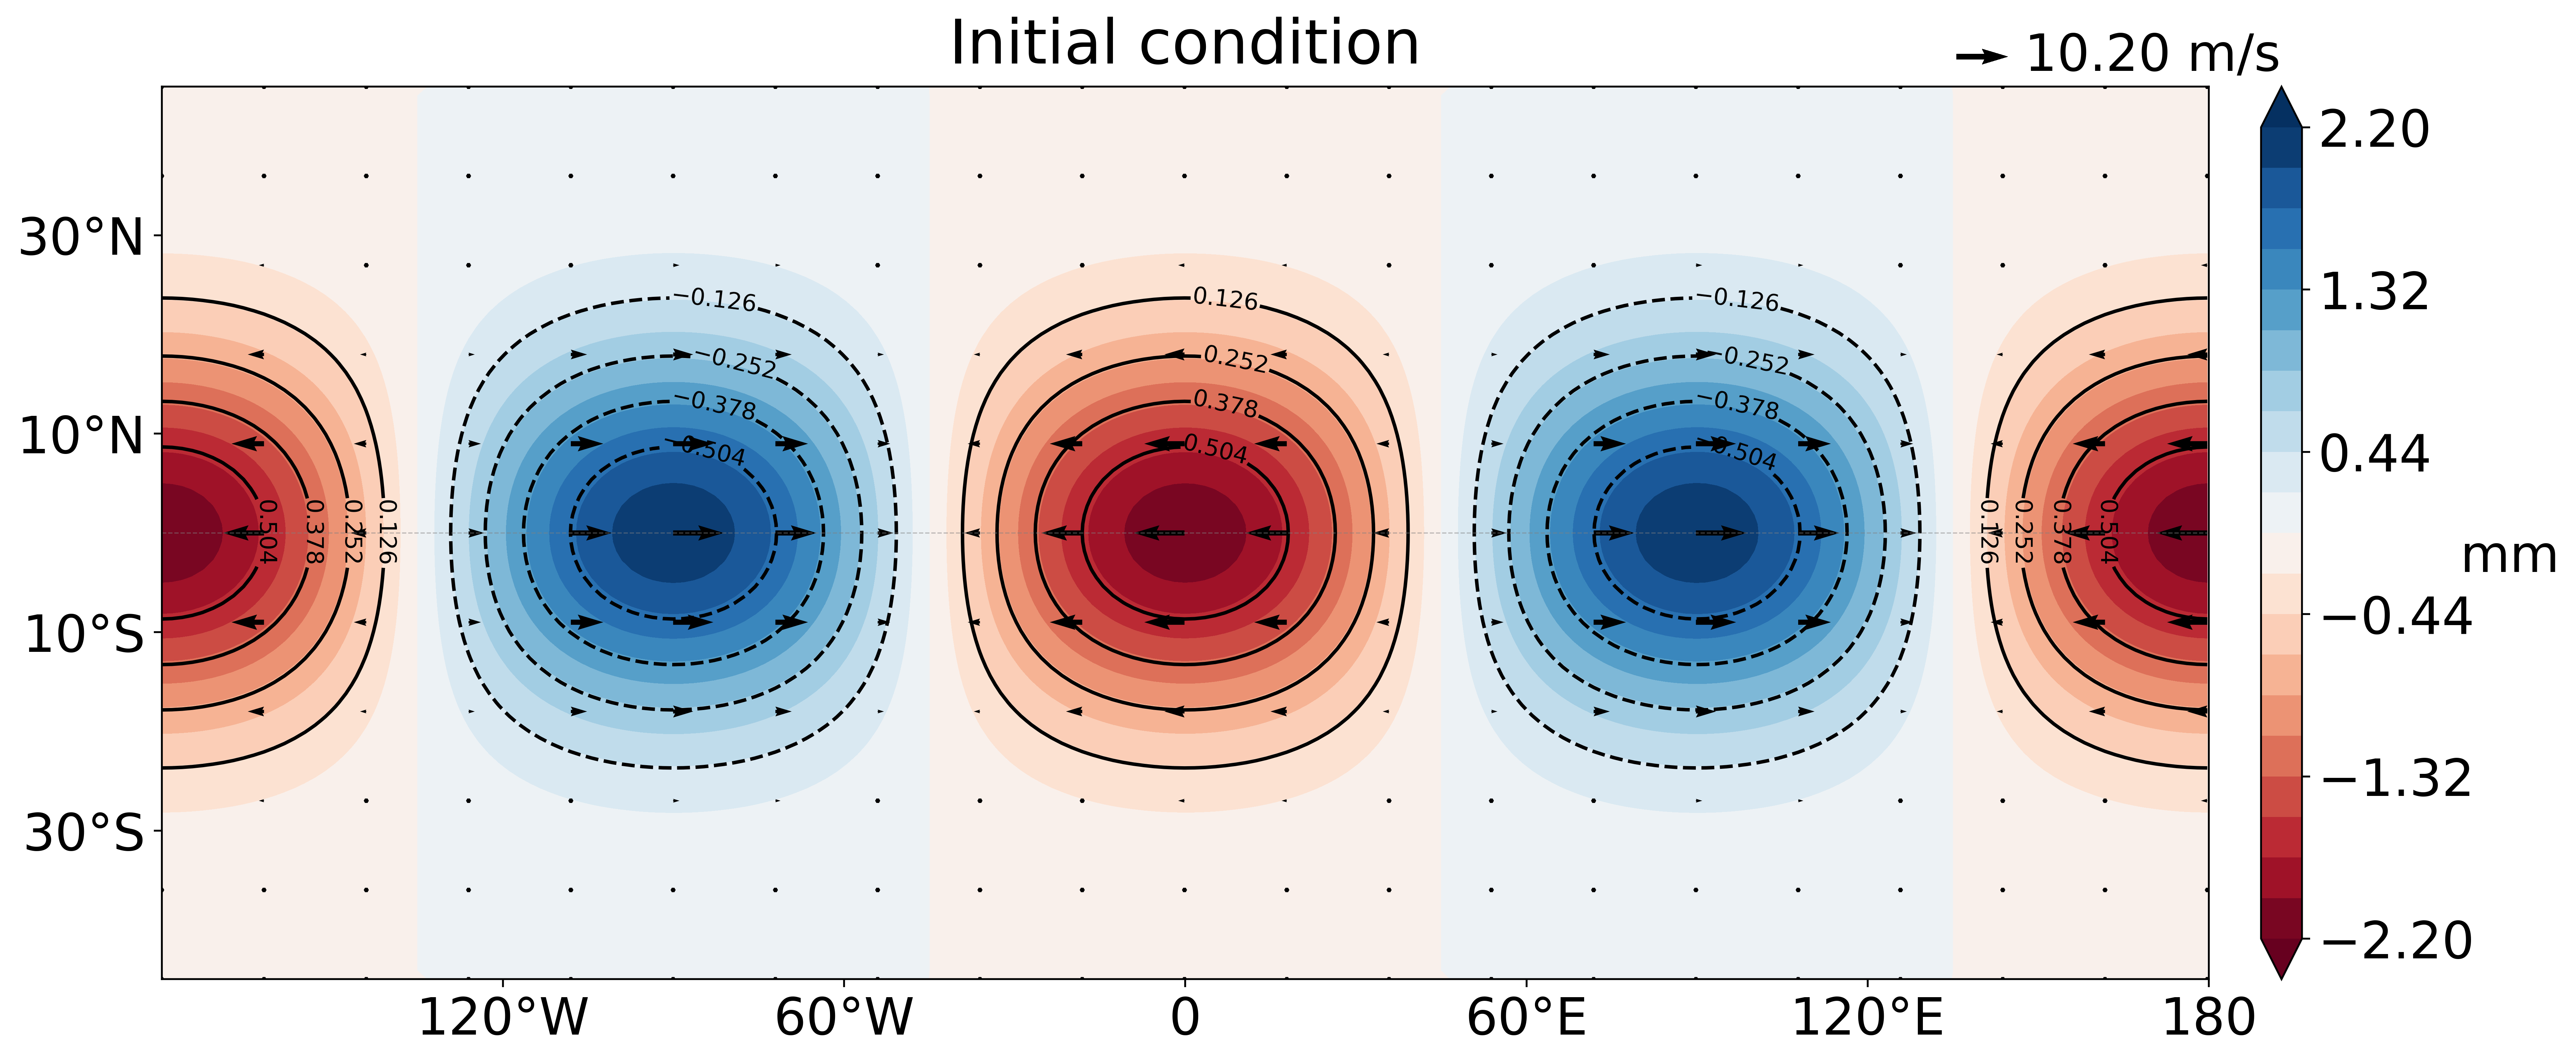

In [34]:
# Specify the type of wave for the initial condition
initial_wave = 'Kelvin'
n_wavelengths = 2
mode_number = 1

initial_condition_name = f"k={n_wavelengths:0.1f}_m={mode_number}_{initial_wave}-wave"

print(f"Output directory: {output_file_directory}")
print(f"Initial condition: {initial_condition_name}")
print(f"===========================================\n")

# #### Generate new initial condition
[
    generated_zonal_velocity,
    generated_meridional_velocity,
    generated_column_temperature,
    generated_column_moisture
] = generate_initial_condition(save_initial_condition=True)

#### Load existing initial condition data
# initial_condition_data = xr.open_dataset(f"{output_file_directory}/{initial_condition_name}_intial-condition-data.nc")
# initial_condition_data = xr.open_dataset(
#     f"/home/disk/eos7/sressel/research/thesis-work/python/numerical_solver/output/WTG/" 
#     + f"epst=0.00_epsq=0.17_r=0.0_nx=1.0_ny=1.0_free-moist-uncoupled-simulation/k=2.0_m=1_Rossby-wave_final-timesteps-model-data_chunk-3of3.nc"
# )
# loaded_zonal_velocity = initial_condition_data['u'].to_numpy()
# loaded_meridional_velocity = initial_condition_data['v'].to_numpy()
# loaded_column_temperature = initial_condition_data['T'].to_numpy()
# loaded_column_moisture = initial_condition_data['q'].to_numpy()

##### Specify which initial condition to use when solving
# Generated
initial_zonal_velocity = generated_zonal_velocity
initial_meridional_velocity = generated_meridional_velocity
initial_column_temperature = generated_column_temperature
initial_column_moisture = generated_column_moisture

# Loaded
# initial_zonal_velocity = loaded_zonal_velocity
# initial_meridional_velocity = loaded_meridional_velocity
# initial_column_temperature = loaded_column_temperature
# initial_column_moisture = loaded_column_moisture

# Plot the initial conditon below
plot_horizontal_structure(
    0,
    zonal_gridpoints,
    meridional_gridpoints,
    time_points,
    zonal_velocity = initial_zonal_velocity, 
    meridional_velocity = initial_meridional_velocity, 
    column_temperature = initial_column_temperature, 
    column_moisture = initial_column_moisture, 
    ylims=(np.min(meridional_gridpoints)/METERS_PER_DEGREE, np.max(meridional_gridpoints)/METERS_PER_DEGREE),
    # ylims=(-60,60),
    save_plot=True
)

# Run Simulation

## Leapfrog Timestepping

In [35]:
# save_downsampled = True
# overwrite_data = input("Overwrite existing data? [y/n]")

# for chunk in range(1, n_chunks+1):
#     chunk_length = nt//n_chunks
#     # chunk_length = nt
    
#     # Initialize the variables to simulate
#     zonal_velocity = np.zeros((chunk_length, ny, nx))
#     meridional_velocity = np.zeros((chunk_length, ny, nx))
#     column_temperature = np.zeros((chunk_length, ny, nx))
#     column_moisture = np.zeros((chunk_length, ny, nx))
    
#     print(f"Chunk {chunk}/{n_chunks}")
    
#     # The first chunk is initialized with preset initial conditions
#     if chunk == 1:
#         zonal_velocity[0] = initial_zonal_velocity[0]
#         meridional_velocity[0] = initial_meridional_velocity[0]
#         column_temperature[0] = initial_column_temperature[0]
#         column_moisture[0] = initial_column_moisture[0]
        
#         zonal_velocity[1] = initial_zonal_velocity[1]
#         meridional_velocity[1] = initial_meridional_velocity[1]
#         column_temperature[1] = initial_column_temperature[1]
#         column_moisture[1] = initial_column_moisture[1]
        
#     # Subsequent chunks are initialized with the output of the previous chunk
#     elif chunk > 1:
#         final_timesteps_model_data_input = xr.open_dataset(
#             f"{output_file_directory}/{initial_condition_name}_final-timesteps-model-data_chunk-{chunk-1}of{n_chunks}.nc"
#         )

#         zonal_velocity[0] = final_timesteps_model_data_input['u'].sel(it=0).to_numpy()
#         meridional_velocity[0] = final_timesteps_model_data_input['v'].sel(it=0).to_numpy()
#         column_temperature[0] = final_timesteps_model_data_input['T'].sel(it=0).to_numpy()
#         column_moisture[0] = final_timesteps_model_data_input['q'].sel(it=0).to_numpy()
        
#         zonal_velocity[1] = final_timesteps_model_data_input['u'].sel(it=1).to_numpy()
#         meridional_velocity[1] = final_timesteps_model_data_input['v'].sel(it=1).to_numpy()
#         column_temperature[1] = final_timesteps_model_data_input['T'].sel(it=1).to_numpy()
#         column_moisture[1] = final_timesteps_model_data_input['q'].sel(it=1).to_numpy()
    
#     ### Step forward using leapfrong time-differencing
#     for it in tqdm(range(2,chunk_length), position=0, leave=True, ncols=100):
#         ### Transform to spectral space
#         ux_fft = fft(zonal_velocity[it-1],axis=1)
#         vy_fft = fft(meridional_velocity[it-1],axis=0)
#         Tx_fft = fft(column_temperature[it-1],axis=1)
#         Ty_fft = fft(column_temperature[it-1],axis=0)

#         ### Compute derivatives
#         dudx_fft = 1j*zonal_wavenumber[None,:]*ux_fft
#         dvdy_fft = 1j*meridional_wavenumber[:,None]*vy_fft
#         dTdx_fft = 1j*zonal_wavenumber[None,:]*Tx_fft
#         dTdy_fft = 1j*meridional_wavenumber[:,None]*Ty_fft

#         ### Transform back to physical space
#         dudx = np.real(ifft(dudx_fft, axis=1))
#         dvdy = np.real(ifft(dvdy_fft, axis=0))
#         dTdx = np.real(ifft(dTdx_fft, axis=1))
#         dTdy = np.real(ifft(dTdy_fft, axis=0))

#         ### Step forward with leapfrog scheme
#         zonal_velocity[it] = (zonal_velocity[it-2] - 2*time_step*(
#             - CORIOLIS_PARAMETER*meridional_gridpoints[:,None]*meridional_velocity[it-1] 
#             + (gravity_wave_phase_speed**2/GROSS_DRY_STABILITY)*dTdx)
#         )

#         meridional_velocity[it] = (meridional_velocity[it-2] - 2*time_step*(
#             + CORIOLIS_PARAMETER*meridional_gridpoints[:,None]*zonal_velocity[it-1] 
#             + (gravity_wave_phase_speed**2/GROSS_DRY_STABILITY)*dTdy)
#         )

#         if moisture_coupling == True:
#             column_temperature[it] = (1/(1+2*TEMPERATURE_SENSITIVITY*(1+CLOUD_RADIATIVE_PARAMETER)*time_step))*(
#                 column_temperature[it-2] 
#                 - 2*time_step*(
#                     + GROSS_DRY_STABILITY*(dudx + dvdy)
#                     - MOISTURE_SENSITIVITY*(1+CLOUD_RADIATIVE_PARAMETER)*column_moisture[it-1]
#                 )
#             )

#         elif moisture_coupling == False:
#             column_temperature[it] = (1/(1+2*TEMPERATURE_SENSITIVITY*(1+CLOUD_RADIATIVE_PARAMETER)*time_step))*(
#                 column_temperature[it-2] 
#                 - 2*time_step*(
#                     + GROSS_DRY_STABILITY*(dudx + dvdy)

#                 )
#             )

#         if simulation_moisture == True:
#             column_moisture[it] = (1/(1+2*MOISTURE_SENSITIVITY*time_step))*(
#                 column_moisture[it-2] 
#                 - 2*time_step*(
#                     - ZONAL_MOISTENING_PARAMETER*zonal_velocity[it-1]
#                     + MERIDIONAL_MOISTENING_PARAMETER*meridional_gridpoints[:,None]*meridional_velocity[it-1] 
#                     - gross_moisture_stratification*(dudx + dvdy)
#                     - TEMPERATURE_SENSITIVITY*column_temperature[it-1]
#                 )
#             )

#         ### Meridional boundary condition
#         meridional_velocity[it,0] = 0.
#         meridional_velocity[it,-1] = 0.
        
        
        
#         # zonal_velocity[it,0] = 0.
#         # zonal_velocity[it,-1] = 0.
        
#         # column_temperature[it,0] = 0.
#         # column_temperature[it,-1] = 0.
        
#         # column_moisture[it,0] = 0.
#         # column_moisture[it,-1] = 0.
    
#     if save_downsampled:       
        
#         downsample_interval = round_to_multiple(np.floor(12*3600/time_step), n_chunks)
#         full_indices = np.array([i * downsample_interval for i in range(len(time_points[::downsample_interval]))])
#         chunked_indices = full_indices % (chunk_length-2)
#         data_indices = chunked_indices[
#             (chunk-1)*(int(len(chunked_indices)/n_chunks)+1):chunk*(int(len(chunked_indices)/n_chunks)+1)
#         ]
#         time_indices = full_indices[
#             (chunk-1)*(int(len(chunked_indices)/n_chunks)+1):chunk*(int(len(chunked_indices)/n_chunks)+1)
#         ]
        
        
#         # Store model variables in an xarray Dataset
#         downsampled_model_data = xr.Dataset(
#             data_vars = {
#                 'u' : (["time", "y", "x"], zonal_velocity[:-2,:,:][data_indices]),
#                 'v' : (["time", "y", "x"], meridional_velocity[:-2,:,:][data_indices]),
#                 'T' : (["time", "y", "x"], column_temperature[:-2,:,:][data_indices]),
#                 'q' : (["time", "y", "x"], column_moisture[:-2,:,:][data_indices])
#             },
#             coords = {
#             "x" : zonal_gridpoints,
#             "y" : meridional_gridpoints,
#             "time" : time_points[time_indices]
#             }
#         )
        
        
#         if os.path.exists(f"{output_file_directory}/{initial_condition_name}_downsampled-model-data_chunk-{chunk}of{n_chunks}.nc"):
#             if overwrite_data == 'y':
#                 os.system(f"rm {output_file_directory}/{initial_condition_name}_downsampled-model-data_chunk-{chunk}of{n_chunks}.nc")
#                 print("Data overwritten")
#                 downsampled_model_data.to_netcdf(
#                     f"{output_file_directory}/{initial_condition_name}_downsampled-model-data_chunk-{chunk}of{n_chunks}.nc"
#                 )
#                 print("Downsampled data saved as netCDF")
            
#         else:
#             # Save the Dataset to a netCDF file
#             downsampled_model_data.to_netcdf(
#                 f"{output_file_directory}/{initial_condition_name}_downsampled-model-data_chunk-{chunk}of{n_chunks}.nc"
#             )

#             print(f"Chunk {chunk} downsampled data saved")

#     # Store the final two time steps of model variables in an xarray Dataset
#     final_timesteps_model_data = xr.Dataset(
#         data_vars = {
#             'u' : (["it", "y", "x"], zonal_velocity[-2:]),
#             'v' : (["it", "y", "x"], meridional_velocity[-2:]),
#             'T' : (["it", "y", "x"], column_temperature[-2:]),
#             'q' : (["it", "y", "x"], column_moisture[-2:])
#         },
#         coords = {
#         "x" : zonal_gridpoints,
#         "y" : meridional_gridpoints,
#         "it": np.array([0,1])
#         }
#     )
    
#     if os.path.exists(f"{output_file_directory}/{initial_condition_name}_final-timesteps-model-data_chunk-{chunk}of{n_chunks}.nc"):
#         if overwrite_data == 'y':
#             os.system(f"rm {output_file_directory}/{initial_condition_name}_final-timesteps-model-data_chunk-{chunk}of{n_chunks}.nc")
#             print("Data overwritten")
#             final_timesteps_model_data.to_netcdf(
#                 f"{output_file_directory}/{initial_condition_name}_final-timesteps-model-data_chunk-{chunk}of{n_chunks}.nc"
#             )
#             print("Final timestep data saved as netCDF")
#     else:
#         # Save the Dataset to a netCDF file
#         final_timesteps_model_data.to_netcdf(
#             f"{output_file_directory}/{initial_condition_name}_final-timesteps-model-data_chunk-{chunk}of{n_chunks}.nc"
#         )

# print("done")

## Runge-Kutta Timestepping

In [41]:
n_rk_steps = 3
save_downsampled = True
# meridional_damping = meridional_damping_function(-45, 45, 5, 1)
meridional_damping = meridional_damping_function(-40, 40, 10, 0.0001)
overwrite_data = input("Overwrite existing data? [y/n]")

for chunk in range(1, n_chunks+1):
    chunk_length = nt//n_chunks
    # chunk_length = nt
    
    # Initialize the variables to simulate
    zonal_velocity = np.zeros((chunk_length, ny, nx))
    meridional_velocity = np.zeros((chunk_length, ny, nx))
    column_temperature = np.zeros((chunk_length, ny, nx))
    column_moisture = np.zeros((chunk_length, ny, nx))
    
    print(f"Chunk {chunk}/{n_chunks}")
    
    # The first chunk is initialized with preset initial conditions
    if chunk == 1:
        zonal_velocity[0] = initial_zonal_velocity[0]
        meridional_velocity[0] = initial_meridional_velocity[0]
        column_temperature[0] = initial_column_temperature[0]
        column_moisture[0] = initial_column_moisture[0]
     
    # Subsequent chunks are initialized with the output of the previous chunk
    elif chunk > 1:
        final_timesteps_model_data_input = xr.open_dataset(
            f"{output_file_directory}/{initial_condition_name}_final-timesteps-model-data_chunk-{chunk-1}of{n_chunks}.nc"
        )

        zonal_velocity[0] = final_timesteps_model_data_input['u'].to_numpy()
        meridional_velocity[0] = final_timesteps_model_data_input['v'].to_numpy()
        column_temperature[0] = final_timesteps_model_data_input['T'].to_numpy()
        column_moisture[0] = final_timesteps_model_data_input['q'].to_numpy()
    
    ### Step forward using leapfrong time-differencing
    for it in tqdm(range(1, chunk_length), position=0, leave=True, ncols=100):
        zonal_velocity_rk = np.zeros((n_rk_steps+1, ny, nx))
        meridional_velocity_rk = np.zeros((n_rk_steps+1, ny, nx))
        column_temperature_rk = np.zeros((n_rk_steps+1, ny, nx))
        column_moisture_rk = np.zeros((n_rk_steps+1, ny, nx))

        zonal_velocity_rk[0] = zonal_velocity[it-1]
        meridional_velocity_rk[0] = meridional_velocity[it-1]
        column_temperature_rk[0] = column_temperature[it-1]
        column_moisture_rk[0] = column_moisture[it-1]
        
        for rk_step in range(1, n_rk_steps+1):
            
            ### Transform to spectral space
            ux_fft = fft(zonal_velocity_rk[rk_step-1],axis=1)
            # uy_fft = fft(zonal_velocity_rk[rk_step-1],axis=0)
            # vx_fft = fft(meridional_velocity_rk[rk_step-1],axis=1)
            vy_fft = fft(meridional_velocity_rk[rk_step-1],axis=0)
            Tx_fft = fft(column_temperature_rk[rk_step-1],axis=1)
            Ty_fft = fft(column_temperature_rk[rk_step-1],axis=0)
    
            ### Compute first derivatives
            dudx_fft = 1j*zonal_wavenumber[None,:]*ux_fft
            # dudy_fft = 1j*meridional_wavenumber[:, None]*uy_fft
            # dvdx_fft = 1j*zonal_wavenumber[None,:]*vx_fft
            dvdy_fft = 1j*meridional_wavenumber[:,None]*vy_fft
            dTdx_fft = 1j*zonal_wavenumber[None,:]*Tx_fft
            dTdy_fft = 1j*meridional_wavenumber[:,None]*Ty_fft

            ### Compute second derivatives
            # dudx_dx_fft = 1j*zonal_wavenumber[None,:]*dudx_fft
            # dudy_dy_fft = 1j*meridional_wavenumber[:, None]*dudy_fft
            # dvdx_dx_fft = 1j*zonal_wavenumber[None,:]*dvdx_fft
            # dvdy_dy_fft = 1j*meridional_wavenumber[:, None]*dvdy_fft
    
            ### Transform back to physical space
            dudx = np.real(ifft(dudx_fft, axis=1))
            # dudy = np.real(ifft(dudy_fft, axis=0))
            # dvdx = np.real(ifft(dvdx_fft, axis=1))
            dvdy = np.real(ifft(dvdy_fft, axis=0))
            dTdx = np.real(ifft(dTdx_fft, axis=1))
            dTdy = np.real(ifft(dTdy_fft, axis=0))

            # dudx_dx = np.real(ifft(dudx_dx_fft, axis=1))
            # dudy_dy = np.real(ifft(dudy_dy_fft, axis=0))
            # dvdx_dx = np.real(ifft(dvdx_dx_fft, axis=1))
            # dvdy_dy = np.real(ifft(dvdy_dy_fft, axis=0))

            # laplacian_u = dudx_dx + dudy_dy
            # laplacian_v = dvdx_dx + dvdy_dy

            zonal_velocity_forcing = (
                + CORIOLIS_PARAMETER*meridional_gridpoints[:,None]*meridional_velocity_rk[rk_step-1] 
                - (gravity_wave_phase_speed**2/GROSS_DRY_STABILITY)*dTdx
                # - meridional_damping[:, None]*zonal_velocity_rk[rk_step-1]
                # + DIFFUSIVITY*laplacian_u
            )

            zonal_velocity_rk[rk_step] = zonal_velocity[it-1] + (time_step/(n_rk_steps - rk_step + 1))*zonal_velocity_forcing

            meridional_velocity_forcing = (
                - CORIOLIS_PARAMETER*meridional_gridpoints[:,None]*zonal_velocity_rk[rk_step-1] 
                - (gravity_wave_phase_speed**2/GROSS_DRY_STABILITY)*dTdy
                # - meridional_damping[:, None]*meridional_velocity_rk[rk_step-1]
                # + DIFFUSIVITY*laplacian_v
            )

            meridional_velocity_rk[rk_step] = meridional_velocity[it-1] + (time_step/(n_rk_steps - rk_step + 1))*meridional_velocity_forcing

            if simulation_moisture == True:
                column_moisture_forcing = (
                    + ZONAL_MOISTENING_PARAMETER*zonal_velocity_rk[rk_step-1]
                    - MERIDIONAL_MOISTENING_PARAMETER*meridional_gridpoints[:,None]*meridional_velocity_rk[rk_step-1]
                    + gross_moisture_stratification*(dudx + dvdy)
                    + TEMPERATURE_SENSITIVITY*column_temperature_rk[rk_step-1]
                    - MOISTURE_SENSITIVITY*column_moisture_rk[rk_step-1]
                    # - meridional_damping[:, None]*column_moisture_rk[rk_step-1]
                )
    
                column_moisture_rk[rk_step] = column_moisture[it-1] + (time_step/(n_rk_steps - rk_step + 1))*column_moisture_forcing


            column_temperature_forcing = (
                - GROSS_DRY_STABILITY*(dudx + dvdy)
                # + MOISTURE_SENSITIVITY*(1+CLOUD_RADIATIVE_PARAMETER)*column_moisture_rk[rk_step-1]
                # - meridional_damping[:, None]*column_temperature_rk[rk_step-1]
            )

            column_temperature_rk[rk_step] = (1/(TEMPERATURE_SENSITIVITY*(1+CLOUD_RADIATIVE_PARAMETER)))*column_temperature_forcing

            meridional_velocity_rk[rk_step, 0] = 0.
            meridional_velocity_rk[rk_step, -1] = 0.

            zonal_velocity_rk[rk_step, 0] = 0.
            zonal_velocity_rk[rk_step, -1] = 0.
            
            column_moisture_rk[rk_step, 0] = 0.
            column_moisture_rk[rk_step, -1] = 0.

        zonal_velocity[it] = zonal_velocity_rk[-1]
        meridional_velocity[it] = meridional_velocity_rk[-1]
        column_temperature[it] = column_temperature_rk[-1]
        column_moisture[it] = column_moisture_rk[-1]

        ### Meridional boundary condition
        meridional_velocity[it,0] = 0.
        meridional_velocity[it,-1] = 0.

        zonal_velocity[it,0] = 0.
        zonal_velocity[it,-1] = 0.
        
        column_moisture[it,0] = 0.
        column_moisture[it,-1] = 0.

    if save_downsampled:       
        
        downsample_interval = round_to_multiple(np.floor(6*3600/time_step), n_chunks)
        full_indices = np.array([i * downsample_interval for i in range(len(time_points[::downsample_interval]))])
        chunked_indices = full_indices % (chunk_length-1)
        data_indices = chunked_indices[
            (chunk-1)*(int(len(chunked_indices)/n_chunks)):chunk*(int(len(chunked_indices)/n_chunks))
        ]
        time_indices = full_indices[
            (chunk-1)*(int(len(chunked_indices)/n_chunks)):chunk*(int(len(chunked_indices)/n_chunks))
        ]
        
        # Store model variables in an xarray Dataset
        downsampled_model_data = xr.Dataset(
            data_vars = {
                'u' : (["time", "y", "x"], zonal_velocity[:-1,:,:][data_indices]),
                'v' : (["time", "y", "x"], meridional_velocity[:-1,:,:][data_indices]),
                'T' : (["time", "y", "x"], column_temperature[:-1,:,:][data_indices]),
                'q' : (["time", "y", "x"], column_moisture[:-1,:,:][data_indices]),
            },
            coords = {
            "x" : zonal_gridpoints,
            "y" : meridional_gridpoints,
            "time" : time_points[time_indices]
            }
        )
        
        
        if os.path.exists(f"{output_file_directory}/{initial_condition_name}_downsampled-model-data_chunk-{chunk}of{n_chunks}.nc"):
            if overwrite_data == 'y':
                os.system(f"rm {output_file_directory}/{initial_condition_name}_downsampled-model-data_chunk-{chunk}of{n_chunks}.nc")
                print("Data overwritten")
                downsampled_model_data.to_netcdf(
                    f"{output_file_directory}/{initial_condition_name}_downsampled-model-data_chunk-{chunk}of{n_chunks}.nc"
                )
                print("Downsampled data saved as netCDF")
            
        else:
            # Save the Dataset to a netCDF file
            downsampled_model_data.to_netcdf(
                f"{output_file_directory}/{initial_condition_name}_downsampled-model-data_chunk-{chunk}of{n_chunks}.nc"
            )

            print(f"Chunk {chunk} downsampled data saved")

    # Store the final time step of model variables in an xarray Dataset
    final_timesteps_model_data = xr.Dataset(
        data_vars = {
            'u' : (["y", "x"], zonal_velocity[-1]),
            'v' : (["y", "x"], meridional_velocity[-1]),
            'T' : (["y", "x"], column_temperature[-1]),
            'q' : (["y", "x"], column_moisture[-1])
        },
        coords = {
        "x" : zonal_gridpoints,
        "y" : meridional_gridpoints,
        }
    )
    
    if os.path.exists(f"{output_file_directory}/{initial_condition_name}_final-timesteps-model-data_chunk-{chunk}of{n_chunks}.nc"):
        if overwrite_data == 'y':
            os.system(f"rm {output_file_directory}/{initial_condition_name}_final-timesteps-model-data_chunk-{chunk}of{n_chunks}.nc")
            print("Data overwritten")
            final_timesteps_model_data.to_netcdf(
                f"{output_file_directory}/{initial_condition_name}_final-timesteps-model-data_chunk-{chunk}of{n_chunks}.nc"
            )
            print("Final timestep data saved as netCDF")
    else:
        # Save the Dataset to a netCDF file
        final_timesteps_model_data.to_netcdf(
            f"{output_file_directory}/{initial_condition_name}_final-timesteps-model-data_chunk-{chunk}of{n_chunks}.nc"
        )
 
print("done")

Overwrite existing data? [y/n] y


Chunk 1/4


  6%|███▋                                                        | 305/4914 [00:08<02:13, 34.63it/s]/tmp/ipykernel_192972/4107829092.py:64: RuntimeWarning: invalid value encountered in multiply
  dTdx_fft = 1j*zonal_wavenumber[None,:]*Tx_fft
/tmp/ipykernel_192972/4107829092.py:65: RuntimeWarning: invalid value encountered in multiply
  dTdy_fft = 1j*meridional_wavenumber[:,None]*Ty_fft
/tmp/ipykernel_192972/4107829092.py:109: RuntimeWarning: invalid value encountered in multiply
  + ZONAL_MOISTENING_PARAMETER*zonal_velocity_rk[rk_step-1]
100%|███████████████████████████████████████████████████████████| 4914/4914 [02:22<00:00, 34.41it/s]


Data overwritten
Downsampled data saved as netCDF
Data overwritten
Final timestep data saved as netCDF
Chunk 2/4


FileNotFoundError: [Errno 2] No such file or directory: b'/home/disk/eos7/sressel/research/thesis-work/python/numerical_solver/output/WTG/epst=0.50_epsq=0.17_r=0.2_nx=0.0_ny=0.0_damped-moist-coupled-simulation/k=2.0_m=1_Kelvin-wave_final-timesteps-model-data_chunk-1of4.nc'

## Compile downsampled data

In [37]:
downsampled_subfiles = sorted(
    glob(
        f"{output_file_directory}/{initial_condition_name}_downsampled-model-data_chunk*of{n_chunks}.nc"
    )
)
    
downsampled_data_list = []
for downsampled_file in downsampled_subfiles:
    print(downsampled_file)
    downsampled_data_chunked = xr.open_dataset(downsampled_file)
    downsampled_data_list.append(downsampled_data_chunked)

downsampled_data = xr.concat(downsampled_data_list, dim='time')

output_zonal_velocity = downsampled_data['u'].to_numpy()
output_meridional_velocity = downsampled_data['v'].to_numpy()
output_column_temperature = downsampled_data['T'].to_numpy()
output_column_moisture = downsampled_data['q'].to_numpy()

output_zonal_gridpoints = downsampled_data.x.to_numpy()
output_meridional_gridpoints = downsampled_data.y.to_numpy()
downsampled_timepoints = downsampled_data.time.to_numpy()

print("downsampled data compiled")

output/WTG/epst=0.50_epsq=0.17_r=0.2_nx=0.0_ny=0.0_damped-moist-coupled-simulation/k=2.0_m=1_Kelvin-wave_downsampled-model-data_chunk-1of4.nc
output/WTG/epst=0.50_epsq=0.17_r=0.2_nx=0.0_ny=0.0_damped-moist-coupled-simulation/k=2.0_m=1_Kelvin-wave_downsampled-model-data_chunk-2of4.nc
output/WTG/epst=0.50_epsq=0.17_r=0.2_nx=0.0_ny=0.0_damped-moist-coupled-simulation/k=2.0_m=1_Kelvin-wave_downsampled-model-data_chunk-3of4.nc
output/WTG/epst=0.50_epsq=0.17_r=0.2_nx=0.0_ny=0.0_damped-moist-coupled-simulation/k=2.0_m=1_Kelvin-wave_downsampled-model-data_chunk-4of4.nc
downsampled data compiled


# Visualize Simulation Output

## Horizontal Structure

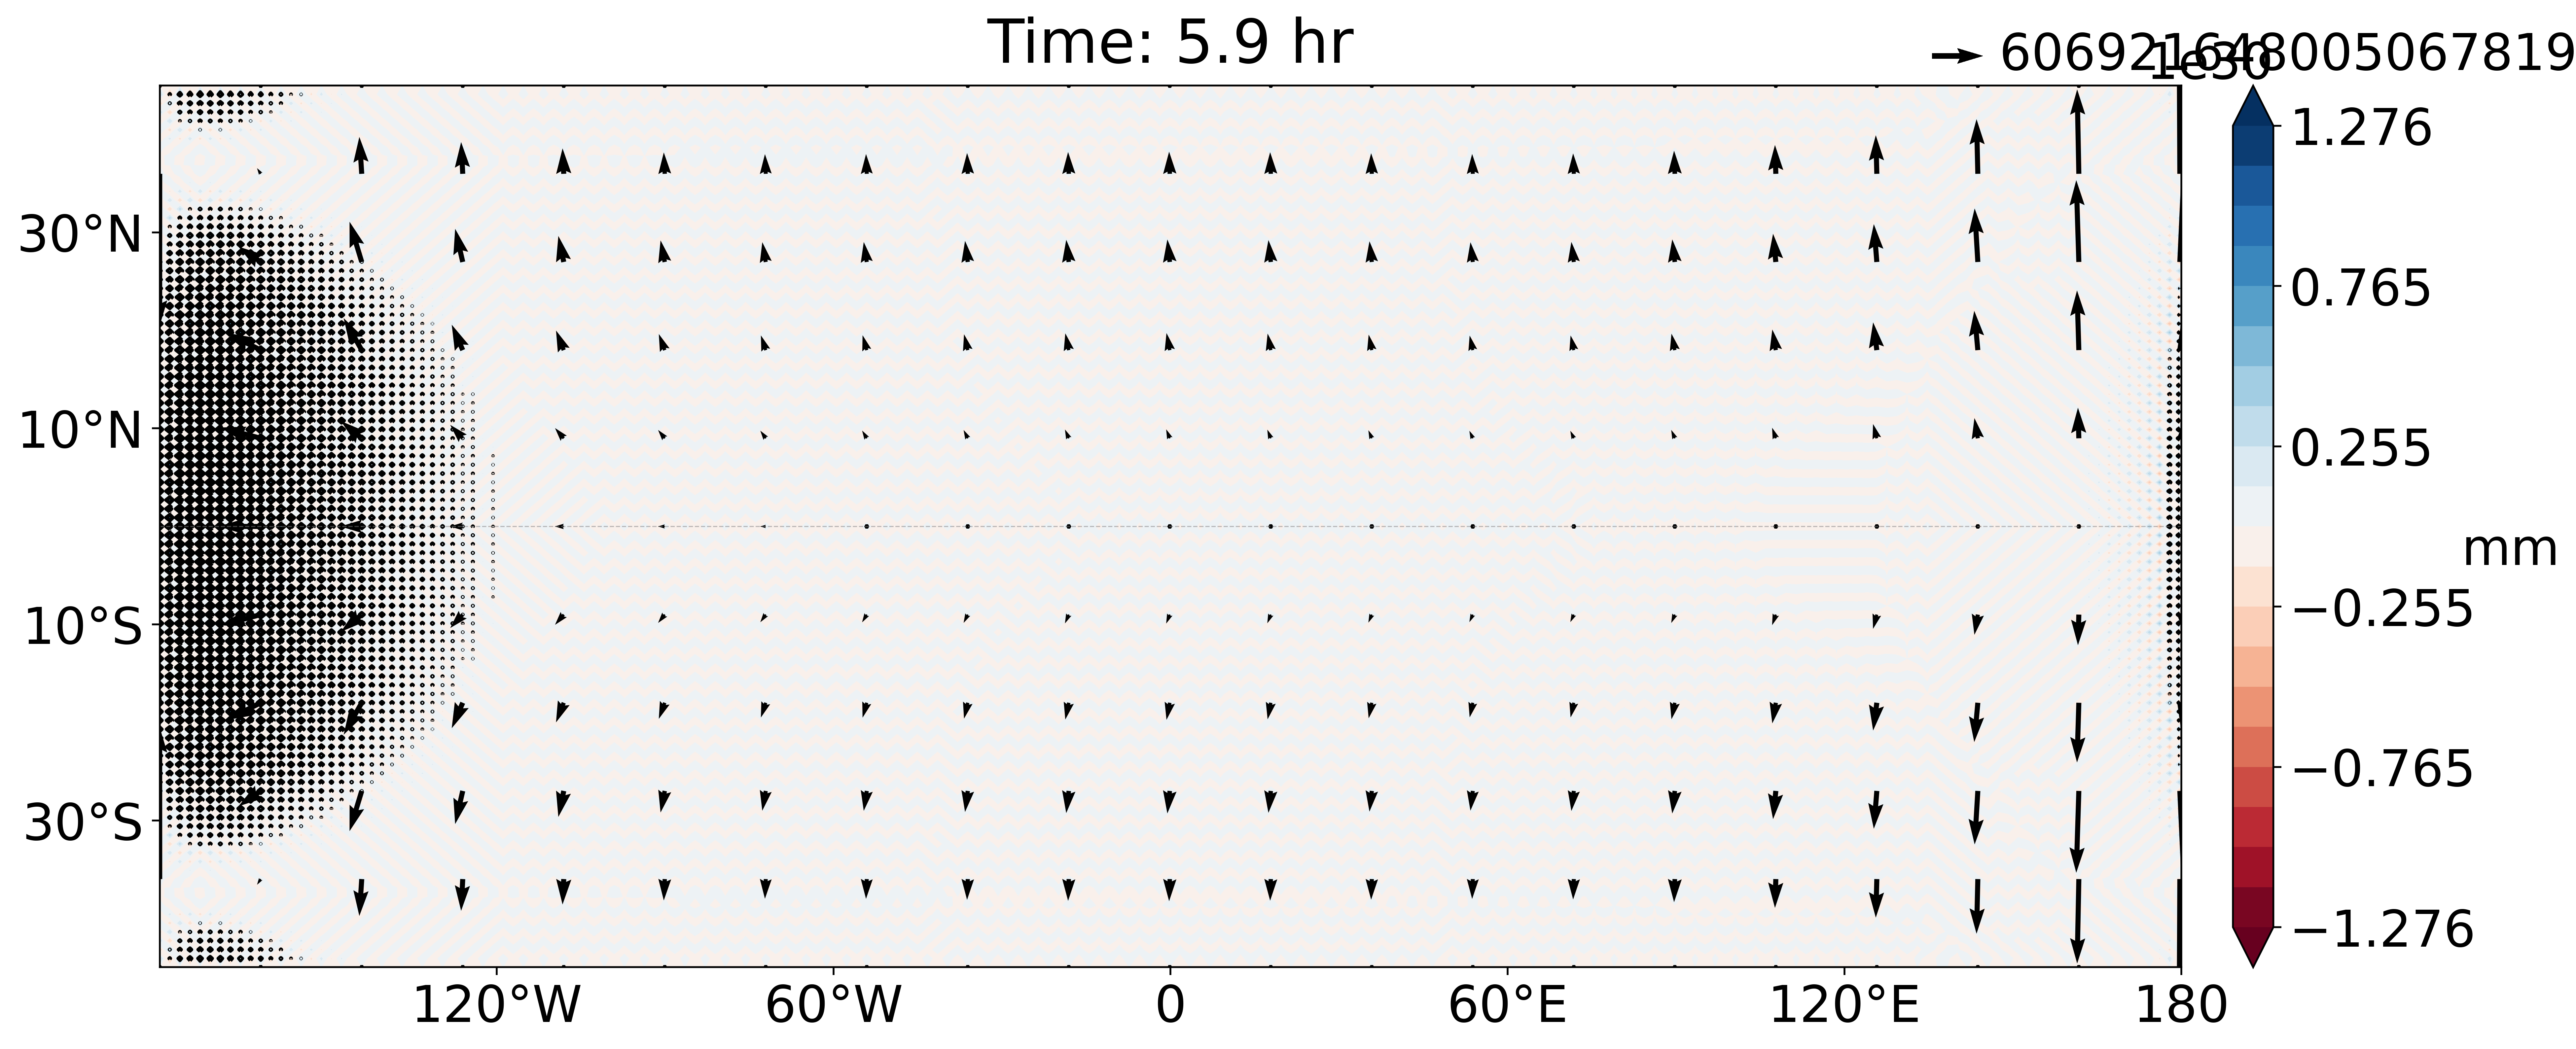

In [38]:
plot_horizontal_structure(
    1,
    output_zonal_gridpoints,
    output_meridional_gridpoints,
    downsampled_timepoints,
    output_zonal_velocity, 
    output_meridional_velocity, 
    output_column_temperature, 
    -output_column_moisture, 
    # ylims=(-60,60),
    ylims = (-np.max(np.abs(meridional_gridpoints/METERS_PER_DEGREE)), np.max(np.abs(meridional_gridpoints/METERS_PER_DEGREE))),
    xlims=(-180,180),
    zonal_quiver_plot_spacing = 10,
    meridional_quiver_plot_spacing = 10, 
    save_plot=False, 
    plotting_units='converted'
)

## Boundary Point Time Evolution

/tmp/ipykernel_4664/4152518191.py:58: RuntimeWarning: invalid value encountered in divide
  output_meridional_velocity[0, lat_index, :]/np.max(np.abs(output_meridional_velocity[0, lat_index,:])),
/tmp/ipykernel_4664/4152518191.py:65: RuntimeWarning: invalid value encountered in divide
  output_meridional_velocity[0, lat_index, :]/np.max(np.abs(output_meridional_velocity[0, lat_index,:])),
 98%|█████████████████████████████████████████████████████████████▍ | 39/40 [00:17<00:00,  2.38it/s]

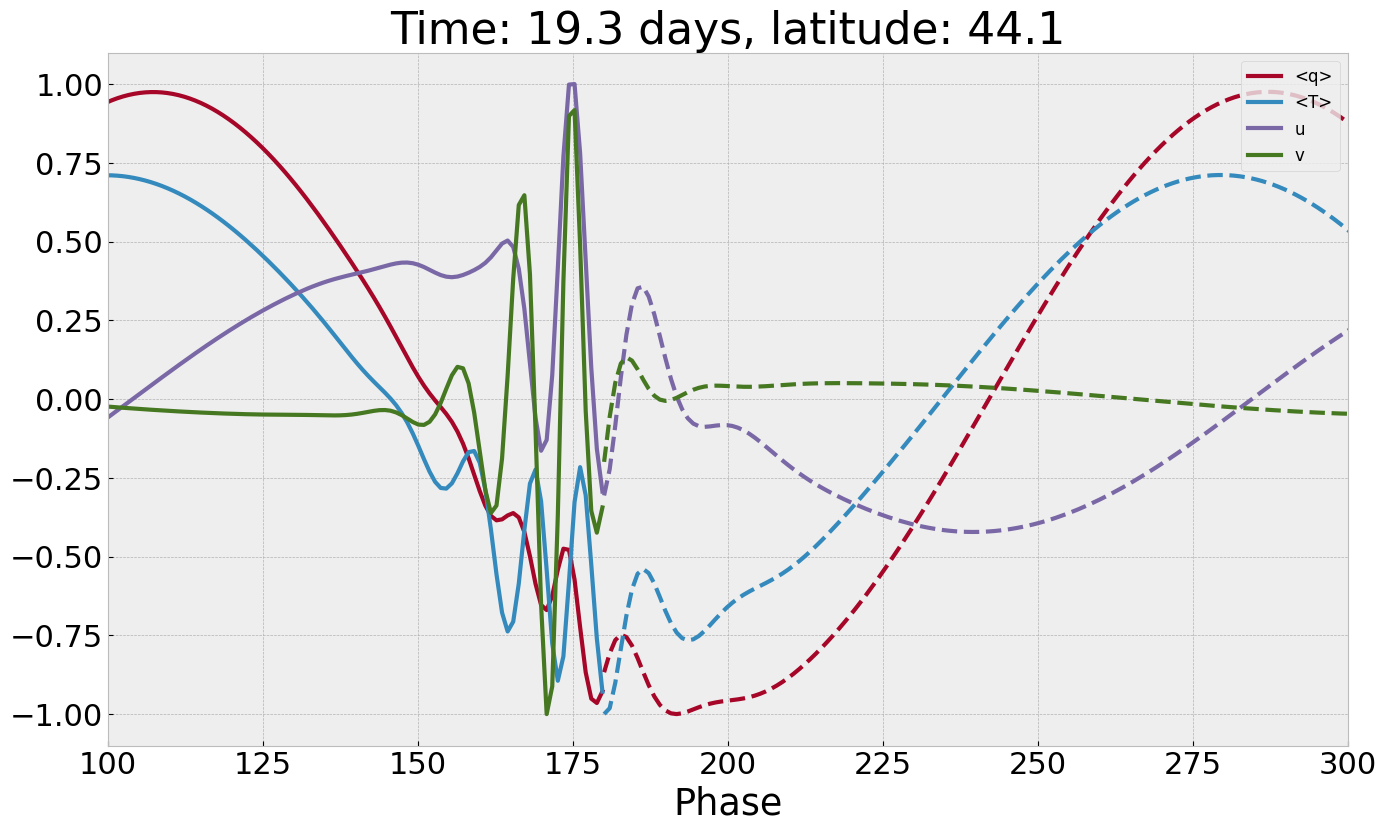

In [16]:
plt.style.use('bmh')
[fig, ax] = plt.subplots(1, 1, figsize=(16,9))

lat_index = -2

# ax.set_title(f"Time: {downsampled_timepoints[0]/SECONDS_PER_DAY:0.1f} days")
ax.set_title(
        f"Time: {downsampled_timepoints[0]/SECONDS_PER_DAY:0.1f} days, latitude: {meridional_gridpoints[lat_index]/METERS_PER_DEGREE:0.1f}"
    )
q_phase1 = ax.plot(
    output_zonal_gridpoints/METERS_PER_DEGREE, 
    output_column_moisture[0,  lat_index, :]/np.max(np.abs(output_column_moisture[0, lat_index,:])), 
    lw=3, 
    color=bmh_colors('red'),
    label='<q>'
)
q_phase2 = ax.plot(
    (zonal_domain_length+output_zonal_gridpoints)/METERS_PER_DEGREE, 
    output_column_moisture[0,  lat_index, :]/np.max(np.abs(output_column_moisture[0, lat_index,:])), 
    lw=3, 
    color=bmh_colors('red'), 
    ls='--'
)

T_phase1 = ax.plot(
    output_zonal_gridpoints/METERS_PER_DEGREE, 
        output_column_temperature[0,  lat_index, :]/np.max(np.abs(output_column_temperature[0, lat_index,:])), 
    lw=3, 
    color=bmh_colors('blue'),
    label='<T>'
)
T_phase2 = ax.plot(
    (zonal_domain_length+output_zonal_gridpoints)/METERS_PER_DEGREE, 
    output_column_temperature[0,  lat_index, :]/np.max(np.abs(output_column_temperature[0, lat_index,:])), 
    lw=3, 
    color=bmh_colors('blue'), 
    ls='--'
)

u_phase1 = ax.plot(
    output_zonal_gridpoints/METERS_PER_DEGREE, 
    output_zonal_velocity[0,  lat_index, :]/np.max(np.abs(output_zonal_velocity[0, lat_index,:])), 
    lw=3, 
    color=bmh_colors('purple'),
    label='u'
)
u_phase2 = ax.plot(
    (zonal_domain_length+output_zonal_gridpoints)/METERS_PER_DEGREE, 
    output_zonal_velocity[0,  lat_index, :]/np.max(np.abs(output_zonal_velocity[0, lat_index,:])), 
    lw=3, 
    color=bmh_colors('purple'), 
    ls='--'
)

# Meridional velocity
v_phase1 = ax.plot(
    output_zonal_gridpoints/METERS_PER_DEGREE, 
    output_meridional_velocity[0, lat_index, :]/np.max(np.abs(output_meridional_velocity[0, lat_index,:])), 
    lw=3, 
    color=bmh_colors('green'),
    label='v'
)
v_phase2 = ax.plot(
    (zonal_domain_length+output_zonal_gridpoints)/METERS_PER_DEGREE, 
    output_meridional_velocity[0, lat_index, :]/np.max(np.abs(output_meridional_velocity[0, lat_index,:])), 
    lw=3, 
    color=bmh_colors('green'), 
    ls='--'
)

ax.legend(loc='upper right', fontsize=12)

ax.set_ylabel('<q>')
ax.set_xlabel('Phase')

ax.set_xlim(100, 300) 
ax.set_ylim(-1.1, 1.1)

def update(frame):

    # Clear the plot each frame
    ax.clear()

    ax.set_title(
        f"Time: {downsampled_timepoints[frame]/SECONDS_PER_DAY:0.1f} days, latitude: {meridional_gridpoints[lat_index]/METERS_PER_DEGREE:0.1f}"
    )

    # Column moisture
    q_phase1 = ax.plot(
        output_zonal_gridpoints/METERS_PER_DEGREE, 
        output_column_moisture[frame, lat_index, :]/np.max(np.abs(output_column_moisture[frame, lat_index,:])), 
        lw=3, 
        color=bmh_colors('red'),
        label='<q>'
    )
    q_phase2 = ax.plot(
        (zonal_domain_length+output_zonal_gridpoints)/METERS_PER_DEGREE, 
        output_column_moisture[frame, lat_index, :]/np.max(np.abs(output_column_moisture[frame, lat_index,:])), 
        lw=3, 
        color=bmh_colors('red'), 
        ls='--'
    )

    # Column temperature
    T_phase1 = ax.plot(
        output_zonal_gridpoints/METERS_PER_DEGREE, 
        output_column_temperature[frame, lat_index, :]/np.max(np.abs(output_column_temperature[frame, lat_index,:])), 
        lw=3, 
        color=bmh_colors('blue'),
        label='<T>'
    )
    T_phase2 = ax.plot(
        (zonal_domain_length+output_zonal_gridpoints)/METERS_PER_DEGREE, 
        output_column_temperature[frame, lat_index, :]/np.max(np.abs(output_column_temperature[frame, lat_index,:])), 
        lw=3, 
        color=bmh_colors('blue'), 
        ls='--'
    )

    # Zonal velocity
    u_phase1 = ax.plot(
        output_zonal_gridpoints/METERS_PER_DEGREE, 
        output_zonal_velocity[frame, lat_index, :]/np.max(np.abs(output_zonal_velocity[frame, lat_index,:])), 
        lw=3, 
        color=bmh_colors('purple'),
        label='u'
    )
    u_phase2 = ax.plot(
        (zonal_domain_length+output_zonal_gridpoints)/METERS_PER_DEGREE, 
        output_zonal_velocity[frame, lat_index, :]/np.max(np.abs(output_zonal_velocity[frame, lat_index,:])), 
        lw=3, 
        color=bmh_colors('purple'), 
        ls='--'
    )

    # Meridional velocity
    v_phase1 = ax.plot(
        output_zonal_gridpoints/METERS_PER_DEGREE, 
        output_meridional_velocity[frame, lat_index, :]/np.max(np.abs(output_meridional_velocity[frame, lat_index,:])), 
        lw=3, 
        color=bmh_colors('green'),
        label='v'
    )
    v_phase2 = ax.plot(
        (zonal_domain_length+output_zonal_gridpoints)/METERS_PER_DEGREE, 
        output_meridional_velocity[frame, lat_index, :]/np.max(np.abs(output_meridional_velocity[frame, lat_index,:])), 
        lw=3, 
        color=bmh_colors('green'), 
        ls='--'
    )
    
    ax.legend(loc='upper right', fontsize=12)
    
    # ax.set_ylabel('')
    ax.set_xlabel('Phase')
    
    ax.set_xlim(100, 300)
    ax.set_ylim(-1.1, 1.1)
    return q_phase1, q_phase2, T_phase1, T_phase2, u_phase1, u_phase2, v_phase1, v_phase2

# Run the animation
anim = FuncAnimation(fig, update, frames = tqdm(range(1, 80, 2), position=0, leave=True, ncols=100), interval=300)

anim.save(
    f"{output_file_directory}/{initial_condition_name}_BC_phase_animation_{time.strftime('%Y%m%d-%H%M')}.mp4", 
    dpi=300
)


## Temporal Structure

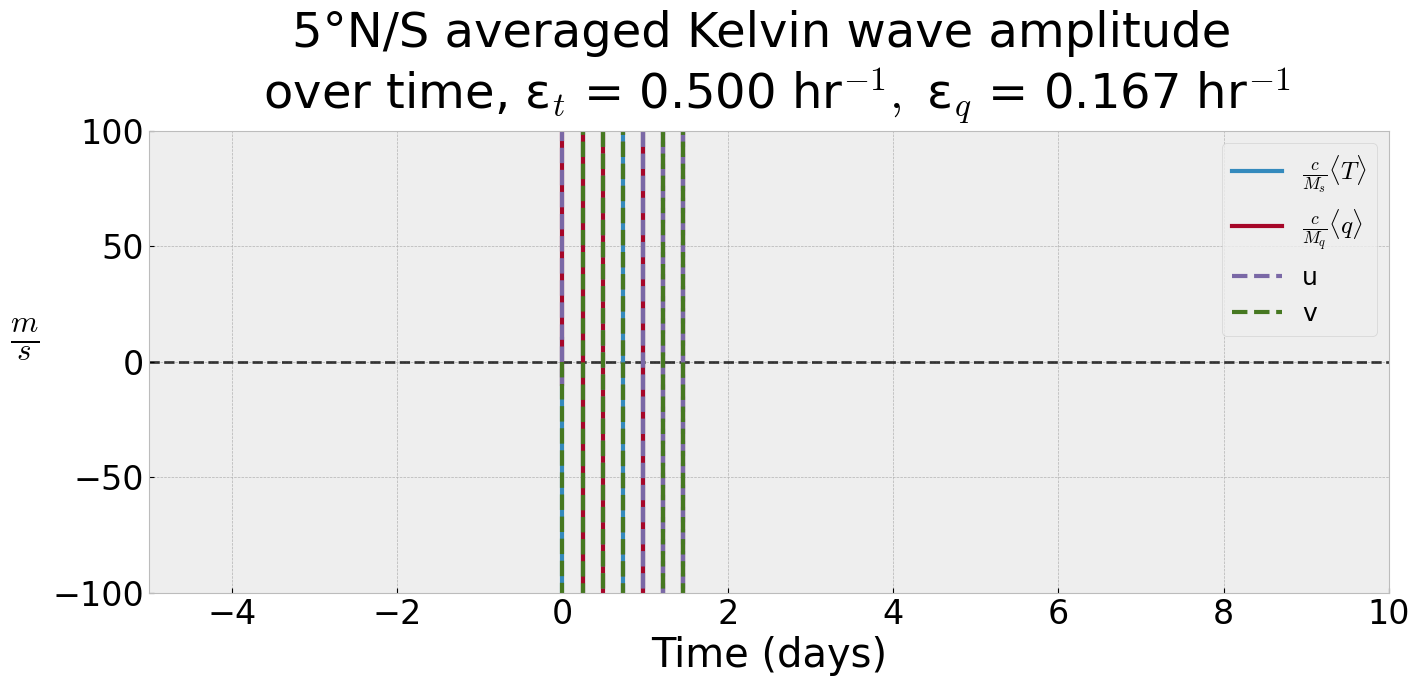

In [40]:
plt.style.use('bmh')
plt.rcParams.update({'font.size':24})

plotting_time_points = downsampled_timepoints

near_equatorial_latitudes = np.where(np.abs(meridional_gridpoints/METERS_PER_DEGREE) <= 5)[0]
near_equatorial_column_temperature = np.mean(
    output_column_temperature[:, near_equatorial_latitudes, :],
    axis=1
)
near_equatorial_column_moisture = np.mean(
    output_column_moisture[:, near_equatorial_latitudes, :],
    axis=1
)
near_equatorial_zonal_velocity = np.mean(
    output_zonal_velocity[:, near_equatorial_latitudes, :],
    axis=1
)
near_equatorial_meridional_velocity = np.mean(
    output_meridional_velocity[:, near_equatorial_latitudes, :],
    axis=1
)

max_index = np.argmax(near_equatorial_column_temperature)
[t_index, x_index] = np.unravel_index(max_index, [nt, nx])

[fig, ax] = plt.subplots(figsize=(16,6))
ax.set_title(
    (
        f"5°N/S averaged {initial_wave} wave amplitude \n over time," 
      + r" ε$_t$ = " + f"{3600*TEMPERATURE_SENSITIVITY:0.3f}" + r" hr$^{-1},$"
      + r" ε$_q$ = " + f"{3600*MOISTURE_SENSITIVITY:0.3f}" + r" hr$^{-1}$"
    ), pad=15
)

ax.axhline(
    y=0,
    color='black',
    ls='--',
    alpha=0.75
)

ax.plot(
    plotting_time_points/SECONDS_PER_DAY, 
    near_equatorial_column_temperature[:, x_index]*gravity_wave_phase_speed/GROSS_DRY_STABILITY, 
    lw=3, 
    label=r"$\frac{c}{M_s}\langle T \rangle$",
    color=bmh_colors('blue')
)

ax.plot(
    plotting_time_points/SECONDS_PER_DAY, 
    near_equatorial_column_moisture[:, x_index]*gravity_wave_phase_speed/gross_moisture_stratification, 
    lw=3, 
    label=r"$\frac{c}{M_q}\langle q \rangle$",
    color=bmh_colors('red')
    
)

ax.plot(
    plotting_time_points/SECONDS_PER_DAY, 
    -near_equatorial_zonal_velocity[:, x_index], 
    lw=3, 
    ls='--',
    label='u',
    color=bmh_colors('purple')
    
)

ax.plot(
    plotting_time_points/SECONDS_PER_DAY, 
    -near_equatorial_meridional_velocity[:, x_index], 
    lw=3, 
    ls='--',
    label='v',
    color=bmh_colors('green')
)

# Maximum column temperature
ax.axhline(
    y=np.max(near_equatorial_column_temperature)*gravity_wave_phase_speed/GROSS_DRY_STABILITY,
    color=bmh_colors('blue'),
    ls=':',
    alpha=0.75
)

ax.axhline(
    y=np.min(near_equatorial_column_temperature)*gravity_wave_phase_speed/GROSS_DRY_STABILITY,
    color=bmh_colors('blue'),
    ls=':',
    alpha=0.75
)

# Maximum column moisture
ax.axhline(
    y=np.max(near_equatorial_column_moisture)*gravity_wave_phase_speed/gross_moisture_stratification,
    color=bmh_colors('red'),
    ls=':',
    alpha=0.75
)

ax.axhline(
    y=np.min(near_equatorial_column_moisture)*gravity_wave_phase_speed/gross_moisture_stratification,
    color=bmh_colors('red'),
    ls=':',
    alpha=0.75
)


ax.set_xlabel('Time (days)')
ax.set_ylabel(r"$\frac{m}{s}$", rotation=0, labelpad=20, fontsize=32)

ax.legend(loc='best', fontsize=18)

if initial_wave == 'EIG' or initial_wave == 'WIG':
    plt.xlim(-1, 5)

    
plt.xlim(-5, 10)
plt.ylim(-100,100)

plt.show()
# plt.savefig(
#     f"{output_file_directory}/{initial_condition_name}_temporal-structure_{time.strftime('%Y%m%d-%H%M')}.png", 
#     bbox_inches='tight'
# )

## Animation

  2%|█▎                                                              | 1/50 [00:02<02:01,  2.49s/it]/tmp/ipykernel_4092925/1835640992.py:189: UserWarning: No contour levels were found within the data range.
  T_cont = ax.contour(
 98%|█████████████████████████████████████████████████████████████▋ | 49/50 [00:34<00:00,  1.23it/s]

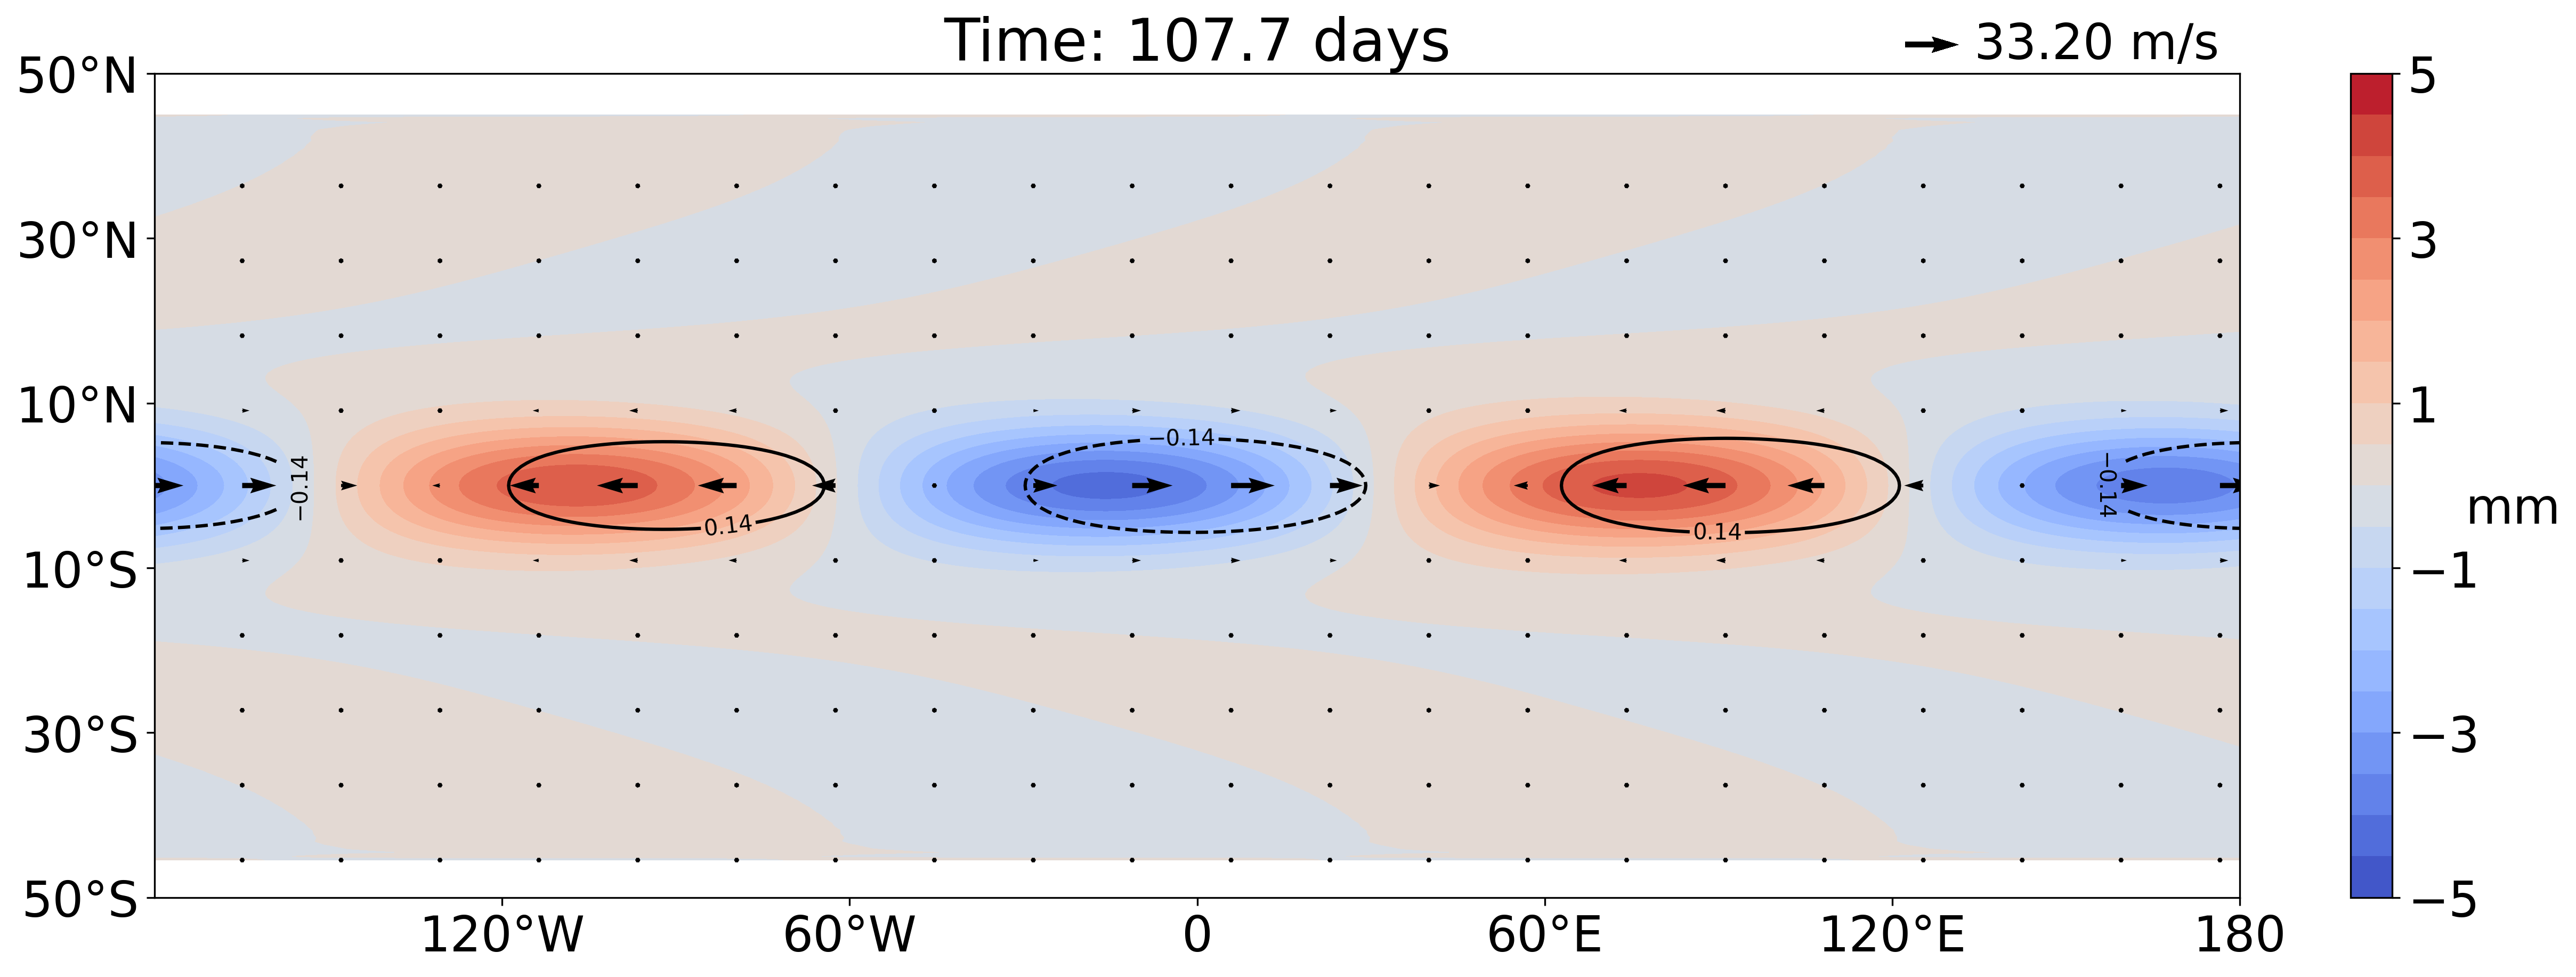

In [601]:
animate_horizontal_structure(
    output_zonal_gridpoints,
    output_meridional_gridpoints,
    downsampled_timepoints,
    output_zonal_velocity, 
    output_meridional_velocity, 
    output_column_temperature, 
    output_column_moisture, 
    n_frames = 50,
    xlims=(-180, 180),
    ylims=(-50,50),
    plotting_units='converted'
)

# Load existing data

In [49]:
loaded_experiment_name = f"epst=0.50_epsq=0.17_r=0.2_nx=1.0_ny=1.0_damped-moist-coupled-simulation"
loaded_initial_condition_name = f"k=2.0_m=1_Kelvin-wave"

loaded_experiment_type = 'Ahmed-21'
loaded_subfiles = sorted(
    glob(f"./output/{loaded_experiment_type}/{loaded_experiment_name}/{loaded_initial_condition_name}_downsampled-model-data_chunk*.nc")
)
    
loaded_data_list = []
for loaded_file in loaded_subfiles:
    loaded_data_chunked = xr.open_dataset(loaded_file)
    loaded_data_list.append(loaded_data_chunked)

loaded_data = xr.concat(loaded_data_list, dim='time')

loaded_zonal_velocity = loaded_data['u'].to_numpy()
loaded_meridional_velocity = loaded_data['v'].to_numpy()
loaded_column_temperature = loaded_data['T'].to_numpy()
loaded_column_moisture = loaded_data['q'].to_numpy()
loaded_zonal_gridpoints = loaded_data.x.to_numpy()
loaded_meridional_gridpoints = loaded_data.y.to_numpy()
loaded_timepoints = loaded_data.time.to_numpy()

print("loaded data compiled")

loaded data compiled


/tmp/ipykernel_2691575/2579061595.py:102: UserWarning: No contour levels were found within the data range.
  T_cont = ax.contour(
  0%|                                                                        | 0/45 [00:00<?, ?it/s]/tmp/ipykernel_2691575/2579061595.py:191: UserWarning: No contour levels were found within the data range.
  T_cont = ax.contour(
 98%|█████████████████████████████████████████████████████████████▌ | 44/45 [00:29<00:00,  1.11it/s]

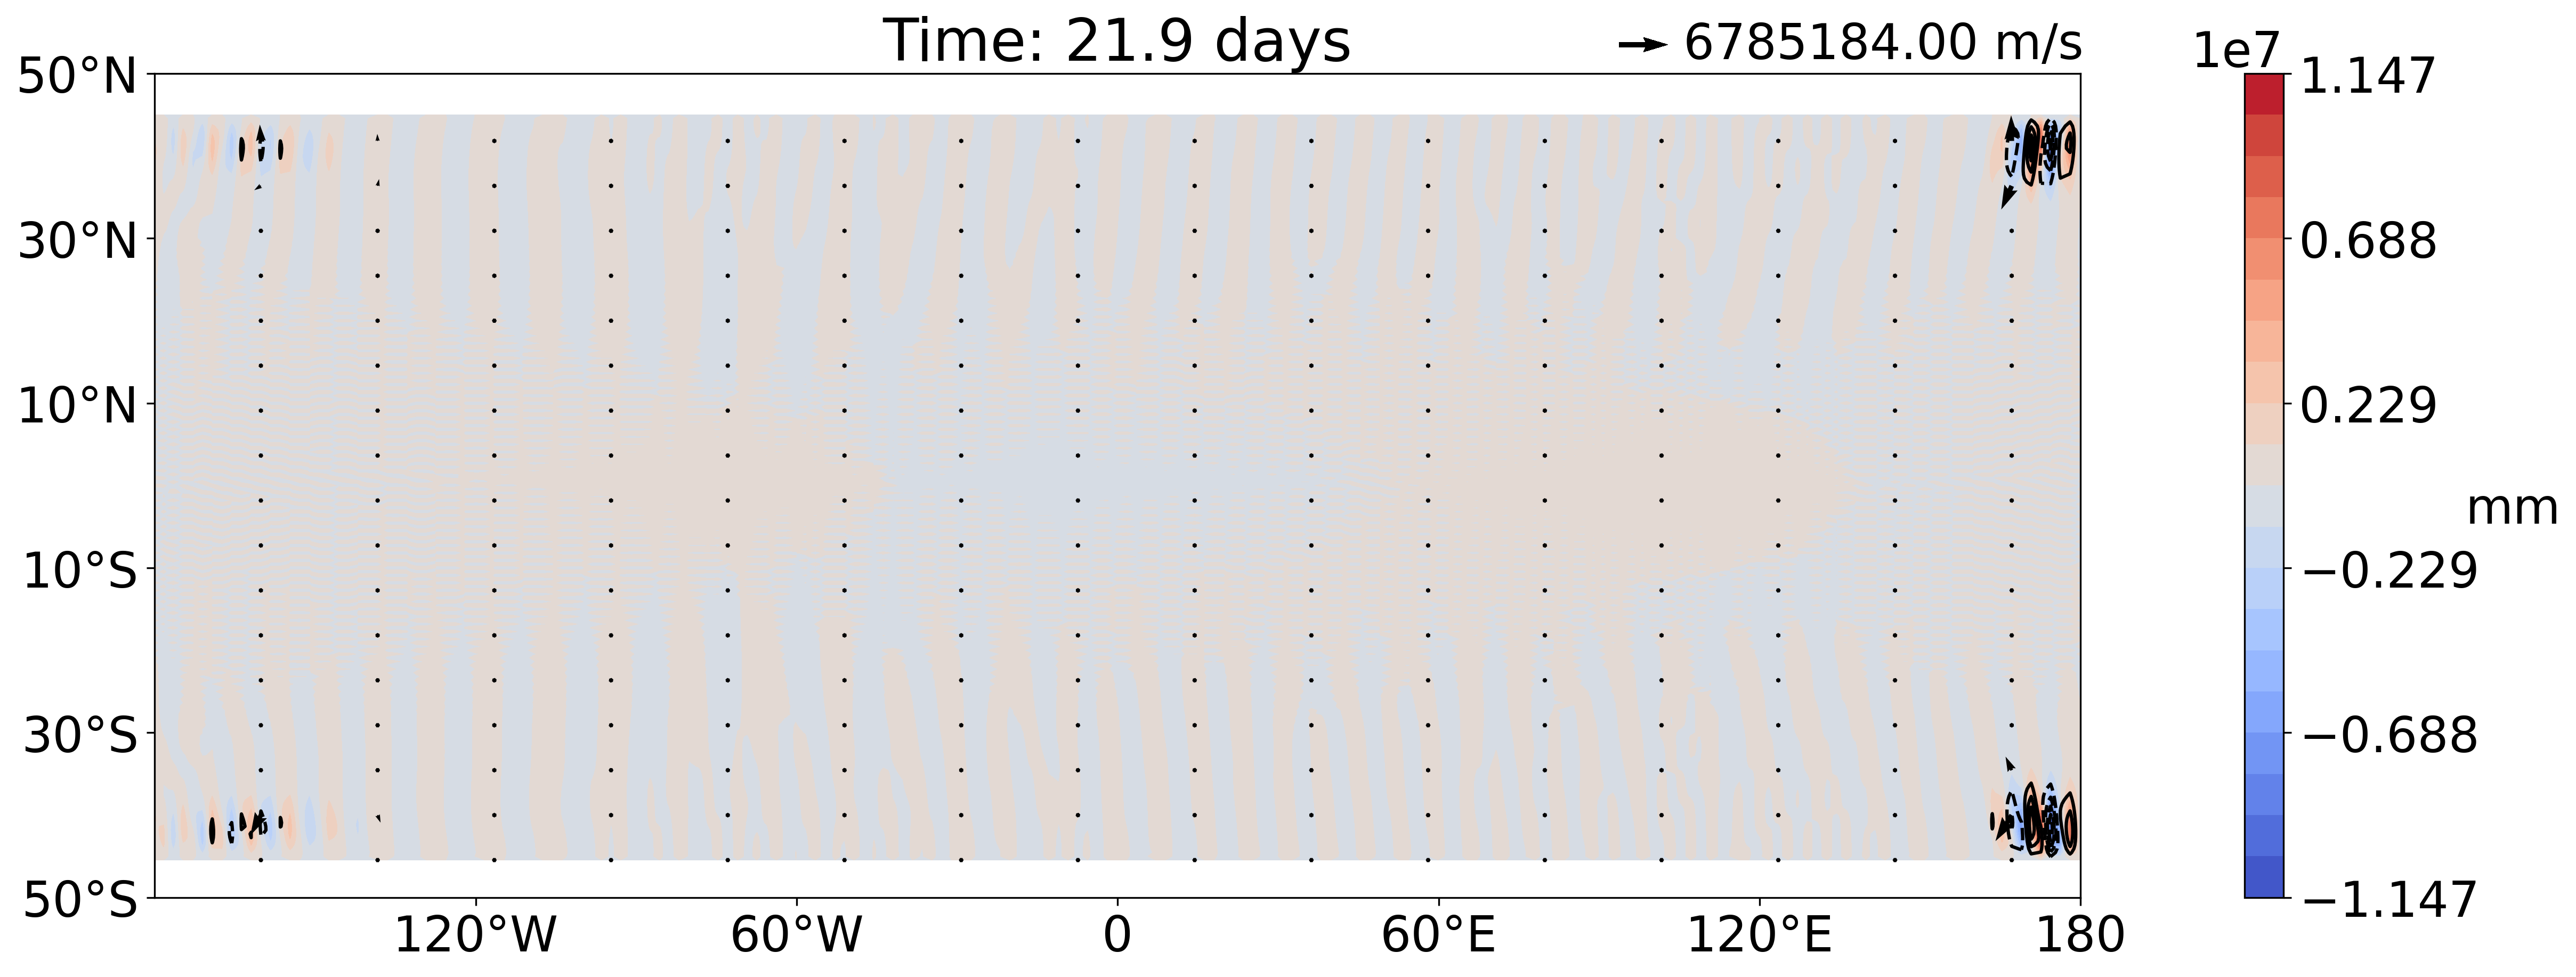

In [105]:
# plot_horizontal_structure(
#     -1,
#     loaded_zonal_gridpoints,
#     loaded_meridional_gridpoints,
#     loaded_timepoints,
#     loaded_zonal_velocity, 
#     loaded_meridional_velocity, 
#     loaded_column_temperature, 
#     loaded_column_moisture, 
#     save_plot=False, 
#     plotting_units='converted'
# )

animate_horizontal_structure(
    loaded_zonal_gridpoints,
    loaded_meridional_gridpoints,
    loaded_timepoints[:45],
    loaded_zonal_velocity[:45], 
    loaded_meridional_velocity[:45], 
    loaded_column_temperature[:45], 
    loaded_column_moisture[:45], 
    n_frames = 45,
    frame_interval = 1,
    xlims=(-180, 180),
    ylims=(-50,50),
    plotting_units='converted'
)

# Tapering functions

In [11]:
def taper_meridionally(data, taper_latitude):
    n_taper = np.shape(np.where(meridional_gridpoints/METERS_PER_DEGREE >= taper_latitude)[0])[0]
    taper_edge = np.cos(np.linspace(0, np.pi/2, n_taper))
    taper_edge[taper_edge < 1e-2] = 0
    taper_center = np.ones((ny-2*n_taper))
    taper = np.concatenate((taper_edge[::-1], taper_center, taper_edge))
    tapered_data = np.einsum(
        'ij,i->ij',
        data,
        taper
    )
    return tapered_data

def meridional_damping_function(starting_latitude, ending_latitude, damping_width, damping_strength):
    def S(x):
        S = np.ones((ny))
        S[x<=0] = 0
        S[(0<x)*(x<1)] = 1/(1+np.exp(1/(x[(0<x)*(x<1)]-1) + 1/x[(0<x)*(x<1)])) 
        S[x>=1] = 1
        return S

    fringe_function = damping_strength*(1 - (
        + S((meridional_gridpoints/METERS_PER_DEGREE - starting_latitude)/damping_width)
        - S(1 + (meridional_gridpoints/METERS_PER_DEGREE - ending_latitude)/damping_width)
    ))
    
    return fringe_function

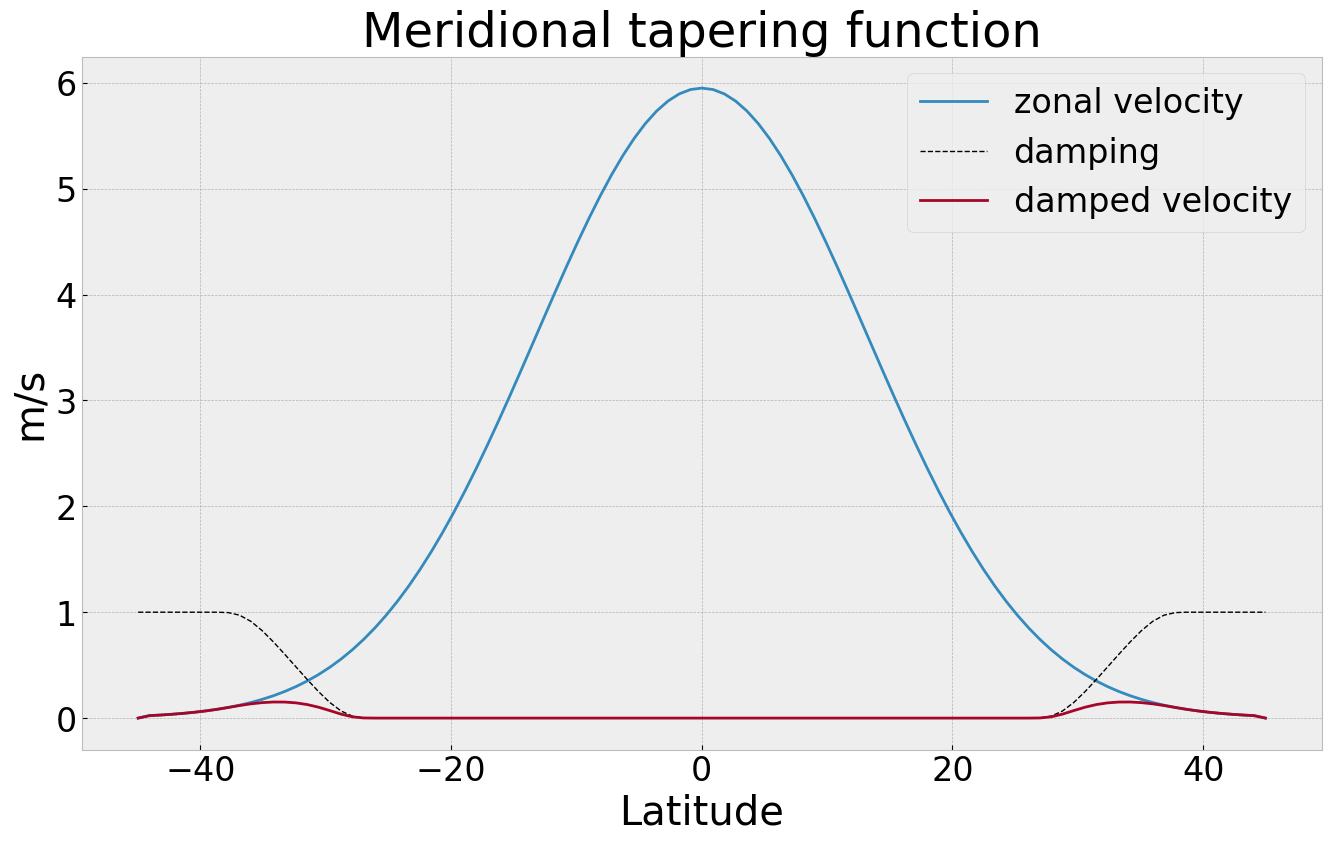

In [55]:
plt.figure(figsize=(16,9))
plt.title("Meridional tapering function")
plt.plot(
    meridional_gridpoints/METERS_PER_DEGREE, 
    output_zonal_velocity[0, :, 15],
    label='zonal velocity'
)
plt.plot(
    meridional_gridpoints/METERS_PER_DEGREE, 
    meridional_damping_function(-40, 40, 15, 1), 
    ls='--', color='k', 
    lw=1, 
    label='damping'
)
plt.plot(
    meridional_gridpoints/METERS_PER_DEGREE, 
    meridional_damping_function(-40, 40, 15, 1)*output_zonal_velocity[0, :, 15], 
    color=bmh_colors('red'),
    label='damped velocity'
)
plt.xlabel("Latitude")
plt.ylabel("m/s")

plt.legend()
plt.show()

# Filtered Solutions

In [ ]:
cutoff_days = 20

low_u = mjo.butter_lowpass_filter(zonal_velocity.T, 1/(cutoff_days*SECONDS_PER_DAY), 1/time_step).T
low_v = mjo.butter_lowpass_filter(meridional_velocity.T, 1/(cutoff_days*SECONDS_PER_DAY), 1/time_step).T
low_T = mjo.butter_lowpass_filter(column_temperature.T, 1/(cutoff_days*SECONDS_PER_DAY), 1/time_step).T
low_q = mjo.butter_lowpass_filter(column_moisture.T, 1/(cutoff_days*SECONDS_PER_DAY), 1/time_step).T

In [ ]:
# phase_speed = np.einsum('i,j->ikj', zonal_wavenumber, frequencies)
frequencies = np.fft.fftfreq(len(time_points), 1/time_step)
phase_speed = -np.repeat(np.einsum('i,j->ji', zonal_wavenumber, frequencies)[:, np.newaxis,:], len(meridional_gridpoints), axis=1)

u_fft = np.fft.fft2(low_u, axes=[0,2])
u_fft[np.where(phase_speed<=0)] = 0
u_east = np.real(np.fft.ifft2(u_fft, axes=[0,2]))

v_fft = np.fft.fft2(low_v, axes=[0,2])
v_fft[np.where(phase_speed<=0)] = 0
v_east = np.real(np.fft.ifft2(v_fft, axes=[0,2]))

T_fft = np.fft.fft2(low_T, axes=[0,2])
T_fft[np.where(phase_speed<=0)] = 0
T_east = np.real(np.fft.ifft2(T_fft, axes=[0,2]))

q_fft = np.fft.fft2(low_q, axes=[0,2])
q_fft[np.where(phase_speed<=0)] = 0
q_east = np.real(np.fft.ifft2(q_fft, axes=[0,2]))
# plt.contourf(np.real(test)[0,:,:], cmap='coolwarm', norm=mcolors.CenteredNorm())

In [ ]:
# # q_fft = np.fft.fft2(low_q, axes=[0,2])
# mask = np.zeros_like(low_u)
# mask[:,:,10] = 1

# u_fft = np.fft.fft2(low_u, axes=[0,2])
# u_fft_masked = u_fft*mask
# u_1 = np.real(np.fft.ifft2(u_fft_masked, axes=[0,2]))

# v_fft = np.fft.fft2(low_v, axes=[0,2])
# v_fft_masked = v_fft*mask
# v_1 = np.real(np.fft.ifft2(v_fft_masked, axes=[0,2]))

# T_fft = np.fft.fft2(low_T, axes=[0,2])
# T_fft_masked = T_fft*mask
# T_1 = np.real(np.fft.ifft2(T_fft_masked, axes=[0,2]))

# q_fft = np.fft.fft2(low_q, axes=[0,2])
# q_fft_masked = q_fft*mask
# q_1 = np.real(np.fft.ifft2(q_fft_masked, axes=[0,2]))